In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
import joblib
from datetime import timedelta
import pandas as pd
from sklearn.preprocessing import normalize
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

pd.set_option('display.max_rows', 10000)

In [3]:
from utilities import *

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
ble = read_ble('../Data/ble.csv')
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')

In [6]:
def read_sequence_rssi(filename):
    rssi = pd.read_csv(filename)
    rssi = rssi.pivot_table(columns="scanner", values="rssi", index="time")
    rssi.rename_axis(None, axis=1, inplace=True)
    rssi.index = pd.to_datetime(rssi.index)
    rssi = rssi.groupby(pd.Grouper(freq='100ms')).mean()
    return rssi

def read_sequence_loc(filename):
    loc = pd.read_csv(filename)
    loc['time'] = pd.to_datetime(loc['time'])
    loc.set_index('time', inplace=True)
    loc = loc.groupby(pd.Grouper(freq='100ms')).mean()
    return loc

In [7]:
rssi = read_sequence_rssi('../Data/sequenceRssi_2.csv')
loc = read_sequence_loc('../Data/sequenceLoc_2.csv')

In [8]:
loc.isna().sum()

X    4197
Y    4197
dtype: int64

In [9]:
def transform(loc, inplace=False):
    if inplace:
        loc['X'] = 24.187023 + loc['X']
        loc['Y'] = 12.252072 - loc['Y']
    else:
        transformed = pd.DataFrame()
        transformed['X'] = 24.187023 + loc['X']
        transformed['Y'] = 12.252072 - loc['Y']
        return transformed

In [10]:
transform(loc, inplace=True)

In [11]:
def show_loc(ori_loc):
    img =  mpimg.imread('../Map/main.png')
    plt.figure(figsize=(40,40))
    plt.imshow(img)
    plt.scatter(ori_loc['X'] * 44, ori_loc['Y'] * 44, alpha=0.2)
    plt.show()

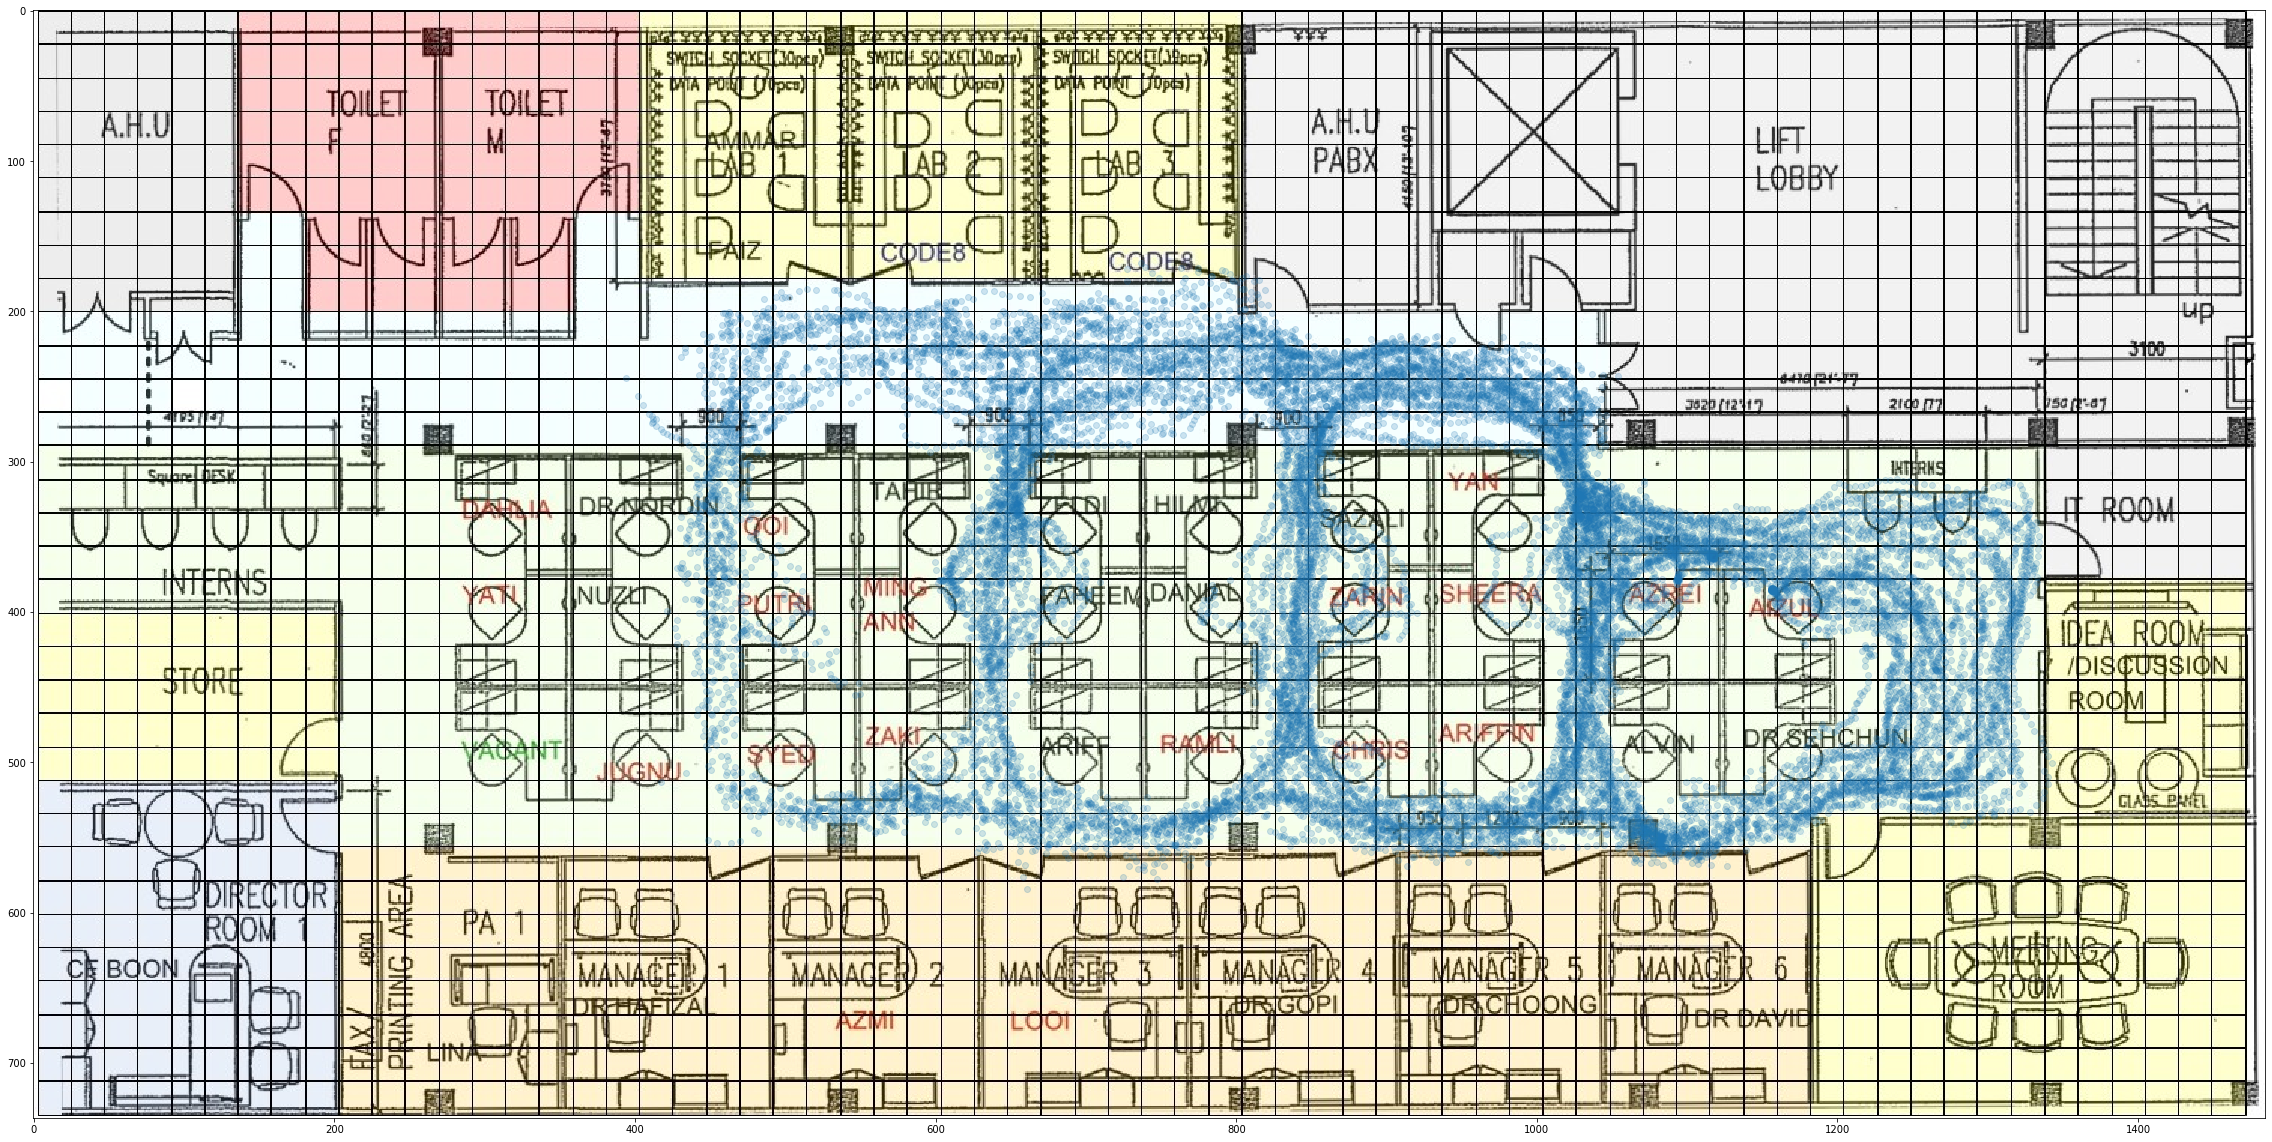

In [12]:
show_loc(loc)

In [13]:
data = rssi.join(loc, how='inner')
data.shape

(24099, 19)

In [14]:
data.isna().sum()

C400A2E19293    22734
CD4533FFC0E1    21704
D2B6503554D7    22246
DB8B36A69C56    22493
DD697EA75B68    22505
DF231643E227    21095
E13B805C6CB0    21136
E43355CA8B96    23051
E6D9D20DD197    22949
E8FD0B453DC4    23183
E96AF2C858BA    20109
EC72840D9AD3    21807
F1307ECB3B90    22149
F1EDAF28E08A    23141
F69A86823B96    21546
FB2EE01C18CE    21883
FDAE5980F28C    22801
X                4197
Y                4197
dtype: int64

In [16]:
def read_stationary_data(filename, number):
    data = read_data(filename)
    data = data.set_index('time').groupby([pd.Grouper('location'), pd.Grouper(freq='100ms')]).mean()
    data = data.groupby('location').tail(number)
    data = data.reset_index(0)
    data["X"] = data["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data["Y"] = data["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    return data[scanners + ['X', 'Y']]

In [17]:
stationary_data_1 = read_stationary_data('../Data/rssi5.csv', 1000)
stationary_data_2 = read_stationary_data('../Data/rssi_2.csv', 1000)

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [18]:
data = pd.concat([stationary_data_1, stationary_data_2, data], axis=0, sort=True)
data.sort_index(inplace=True)

In [19]:
data.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count   5901.000000   5889.000000   4914.000000   6720.000000   5785.000000   
mean     -73.818406    -74.797858    -77.327381    -73.559177    -73.074575   
std        8.710221      7.500665      7.258337      8.736251      6.830462   
min      -97.000000    -98.000000    -98.000000    -98.000000    -97.000000   
25%      -80.000000    -80.000000    -82.000000    -80.000000    -77.000000   
50%      -72.000000    -74.000000    -77.000000    -73.000000    -72.000000   
75%      -68.000000    -69.000000    -72.000000    -66.000000    -68.000000   
max      -48.000000    -52.000000    -53.000000    -56.000000    -52.000000   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count   7013.000000   7176.000000   6368.000000   9820.000000   4167.000000   
mean     -73.789767    -74.670945    -74.664829    -76.628943    -78.453564   
std        8.650418      9.052630      8.916216     11.377744     10.038326   
min      -98.000000    -98.000000    -98.000000    -98.000000    -98.000000   
25%      -80.000000    -82.000000    -82.000000    -85.000000    -87.000000   
50%      -73.000000    -75.000000    -74.000000    -77.000000    -79.000000   
75%      -67.000000    -68.000000    -68.000000    -70.000000    -71.000000   
max      -48.000000    -53.000000    -57.000000    -49.000000    -58.000000   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count   7124.000000   6161.000000   7502.000000   6638.000000   6469.000000   
mean     -76.414292    -72.088817    -69.148005    -77.580841    -74.462217   
std       10.206880      7.602010      7.980605      9.656179      8.557941   
min      -98.000000    -96.000000    -96.000000    -98.000000    -98.000000   
25%      -85.000000    -77.000000    -75.000000    -86.500000    -80.500000   
50%      -76.000000    -72.000000    -68.000000    -76.000000    -75.000000   
75%      -67.000000    -67.000000    -64.000000    -70.000000    -69.000000   
max      -49.000000    -51.000000    -48.000000    -57.000000    -51.000000   

       FB2EE01C18CE  FDAE5980F28C             X             Y  
count   4261.000000   5810.000000  47749.000000  47749.000000  
mean     -82.345115    -75.664400     17.528898      8.497170  
std        8.319674      8.145739      7.522185      2.737330  
min      -98.000000    -98.000000      5.180690      3.915325  
25%      -90.000000    -82.000000     11.176600      5.297530  
50%      -84.000000    -75.000000     18.691700      8.203950  
75%      -75.000000    -69.000000     23.244200     11.717700  
max      -64.000000    -56.000000     30.135649     12.843796

In [20]:
test_rssi = read_sequence_rssi('../Data/testSequenceRssi.csv')
test_loc = read_sequence_loc('../Data/testSequenceLoc.csv')

In [21]:
test_loc.isna().sum()

X    995
Y    995
dtype: int64

In [22]:
transform(test_loc, inplace=True)

In [23]:
test_loc = test_loc.interpolate(method='linear')
test_loc = test_loc[test_loc['X'] >= 11.5]

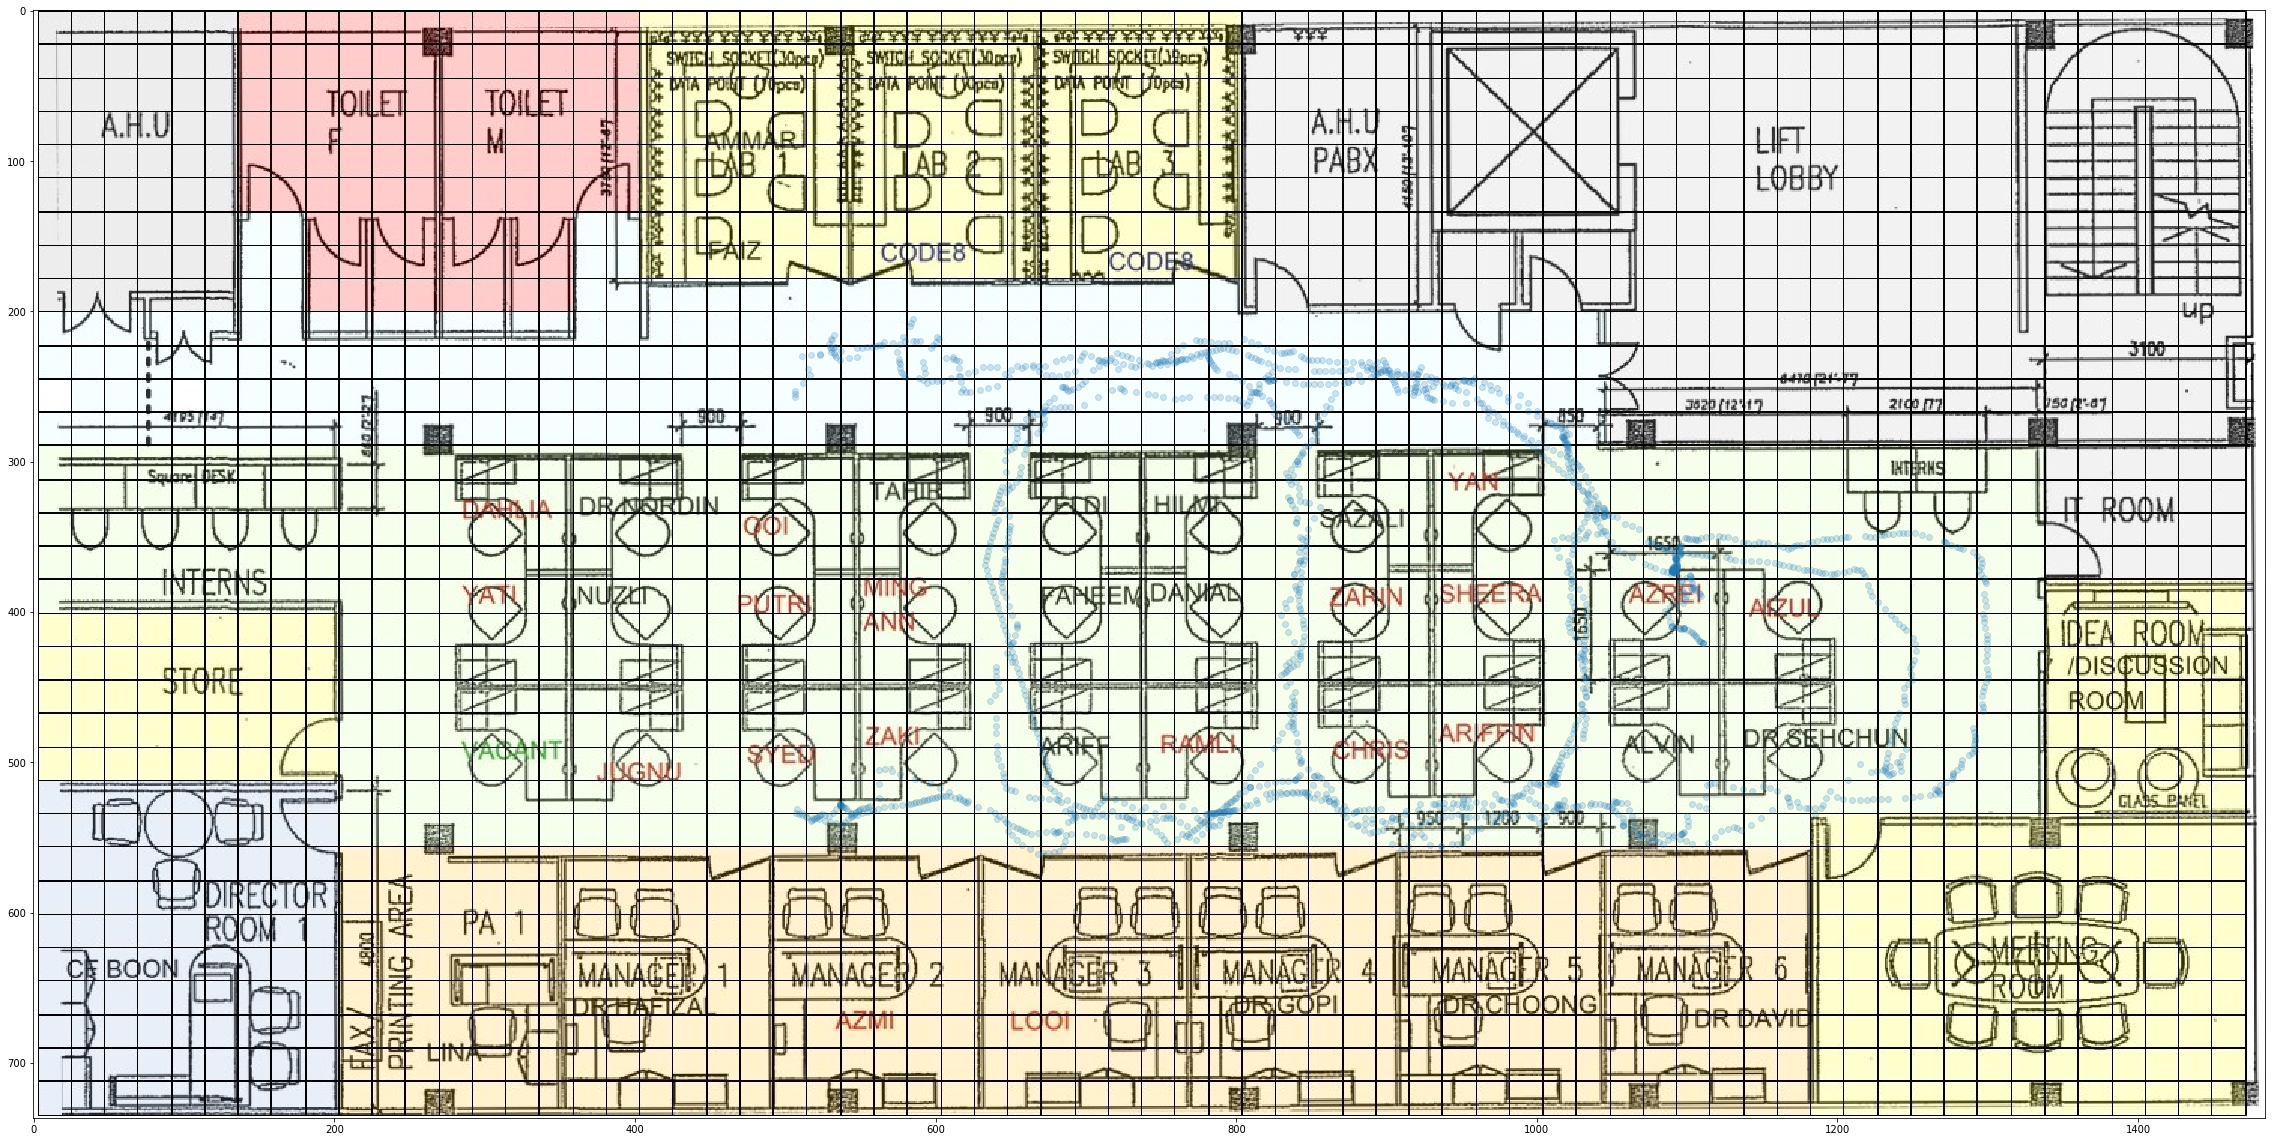

In [24]:
show_loc(test_loc)

In [25]:
test = test_rssi.join(test_loc, how='inner')
test.shape

(1791, 19)

In [26]:
test.isna().sum()

C400A2E19293    1644
CD4533FFC0E1    1590
D2B6503554D7    1615
DB8B36A69C56    1611
DD697EA75B68    1573
DF231643E227    1470
E13B805C6CB0    1430
E43355CA8B96    1642
E6D9D20DD197    1349
E8FD0B453DC4    1697
E96AF2C858BA    1423
EC72840D9AD3    1579
F1307ECB3B90    1528
F1EDAF28E08A    1595
F69A86823B96    1614
FB2EE01C18CE    1480
FDAE5980F28C    1659
X                  0
Y                  0
dtype: int64

In [27]:
stationary_test_1 = read_stationary_data('../Data/testRssi.csv', 500)
stationary_test_2 = read_stationary_data('../Data/testRssi_2.csv', 500)

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [28]:
test = pd.concat([stationary_test_1, stationary_test_2, test], axis=0, sort=True)
test.sort_index(inplace=True)

In [29]:
test.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count   1755.000000   1775.000000   1556.000000   1819.000000   1978.000000   
mean     -73.789601    -74.734742    -77.107219    -75.651274    -72.712799   
std        9.179634      8.084599      6.584462      7.458746      7.916102   
min      -96.000000    -96.000000    -96.000000    -98.000000    -97.000000   
25%      -81.000000    -80.000000    -81.000000    -80.000000    -77.000000   
50%      -72.000000    -75.000000    -77.000000    -75.000000    -72.000000   
75%      -66.000000    -70.000000    -73.000000    -71.000000    -67.000000   
max      -49.000000    -54.000000    -53.000000    -53.000000    -48.000000   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count   2420.000000   2174.000000   1770.000000   2457.000000   1305.000000   
mean     -69.930131    -74.126342    -76.271563    -79.752578    -78.937548   
std        9.988669      8.194151      8.944339      7.722535     10.345345   
min      -98.000000    -98.000000    -98.000000    -97.000000    -98.000000   
25%      -78.000000    -80.000000    -84.000000    -87.000000    -88.000000   
50%      -68.000000    -73.000000    -75.000000    -80.000000    -80.000000   
75%      -63.000000    -67.000000    -68.000000    -73.000000    -70.000000   
max      -48.000000    -51.000000    -62.000000    -52.000000    -56.000000   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count   2352.000000   1927.000000   2145.000000   1866.000000   1787.000000   
mean     -76.441709    -72.660612    -71.146309    -76.988844    -77.185628   
std        8.934105      7.502820      7.288670     10.396325      8.012276   
min      -98.000000    -94.000000    -96.000000    -98.000000    -98.000000   
25%      -83.000000    -77.500000    -76.000000    -86.000000    -83.333333   
50%      -74.000000    -73.000000    -70.000000    -75.000000    -76.000000   
75%      -69.000000    -68.000000    -66.000000    -68.000000    -71.000000   
max      -51.000000    -51.000000    -48.000000    -61.000000    -53.000000   

       FB2EE01C18CE  FDAE5980F28C             X             Y  
count   1535.000000   1665.000000  13335.000000  13335.000000  
mean     -82.422421    -75.078689     17.410376      9.049733  
std        7.806431      8.614748      7.176008      2.513730  
min      -97.000000    -98.000000      5.626103      4.554205  
25%      -89.000000    -80.000000     10.191480      6.570950  
50%      -83.500000    -74.000000     18.790348      9.659024  
75%      -76.000000    -70.000000     23.355726     11.888763  
max      -63.000000    -55.000000     29.934250     12.750413

In [30]:
def impute(data):
    data.update(data.rolling('5s').mean())
    data.ffill(inplace=True)

In [31]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        ss.index = data.index
        data[s].fillna(ss, inplace=True)

In [32]:
impute(data)
linear_impute(data)
data[scanners] = normalize(data[scanners] + 100)

In [33]:
data

C400A2E19293  CD4533FFC0E1  D2B6503554D7  \
time                                                                
2019-12-02 01:05:34.200      0.122956      0.244372      0.210728   
2019-12-02 01:05:34.300      0.119290      0.237086      0.204445   
2019-12-02 01:05:34.400      0.120287      0.239068      0.206154   
2019-12-02 01:05:34.500      0.118465      0.235447      0.203031   
2019-12-02 01:05:34.600      0.113798      0.226172      0.195034   
...                               ...           ...           ...   
2020-01-15 02:48:21.400      0.145406      0.301997      0.251664   
2020-01-15 02:48:21.500      0.146185      0.303615      0.253013   
2020-01-15 02:48:21.600      0.147422      0.304767      0.245704   
2020-01-15 02:48:21.700      0.146662      0.303195      0.244437   
2020-01-15 02:48:21.800      0.146603      0.303073      0.228362   

                         DB8B36A69C56  DD697EA75B68  DF231643E227  \
time                                                                
2019-12-02 01:05:34.200      0.165394      0.217956      0.345732   
2019-12-02 01:05:34.300      0.160462      0.211457      0.335423   
2019-12-02 01:05:34.400      0.161804      0.213224      0.401423   
2019-12-02 01:05:34.500      0.159353      0.209995      0.395343   
2019-12-02 01:05:34.600      0.153076      0.201723      0.379770   
...                               ...           ...           ...   
2020-01-15 02:48:21.400      0.215872      0.212517      0.393715   
2020-01-15 02:48:21.500      0.217029      0.213655      0.381081   
2020-01-15 02:48:21.600      0.218865      0.215463      0.367138   
2020-01-15 02:48:21.700      0.217737      0.242556      0.365245   
2020-01-15 02:48:21.800      0.217648      0.242458      0.365097   

                         E13B805C6CB0  E43355CA8B96  E6D9D20DD197  \
time                                                                
2019-12-02 01:05:34.200      0.328884      0.105198      0.385462   
2019-12-02 01:05:34.300      0.319077      0.102061      0.373968   
2019-12-02 01:05:34.400      0.279780      0.102915      0.322355   
2019-12-02 01:05:34.500      0.275542      0.101356      0.317473   
2019-12-02 01:05:34.600      0.264688      0.097363      0.333737   
...                               ...           ...           ...   
2020-01-15 02:48:21.400      0.298801      0.145406      0.281864   
2020-01-15 02:48:21.500      0.300804      0.146185      0.283374   
2020-01-15 02:48:21.600      0.303350      0.147422      0.285566   
2020-01-15 02:48:21.700      0.301785      0.146662      0.285803   
2020-01-15 02:48:21.800      0.301663      0.146603      0.285687   

                         E8FD0B453DC4  E96AF2C858BA  EC72840D9AD3  \
time                                                                
2019-12-02 01:05:34.200      0.034043      0.407985      0.201121   
2019-12-02 01:05:34.300      0.033028      0.395820      0.195124   
2019-12-02 01:05:34.400      0.033304      0.399129      0.196755   
2019-12-02 01:05:34.500      0.032799      0.393084      0.193776   
2019-12-02 01:05:34.600      0.031507      0.448819      0.186142   
...                               ...           ...           ...   
2020-01-15 02:48:21.400      0.100666      0.297026      0.260053   
2020-01-15 02:48:21.500      0.101205      0.298617      0.261446   
2020-01-15 02:48:21.600      0.102062      0.301145      0.263659   
2020-01-15 02:48:21.700      0.101535      0.299592      0.262299   
2020-01-15 02:48:21.800      0.101494      0.302227      0.274678   

                         F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
time                                                                
2019-12-02 01:05:34.200      0.189209      0.005838      0.261119   
2019-12-02 01:05:34.300      0.183567      0.005664      0.247302   
2019-12-02 01:05:34.400      0.185102      0.005712      0.249369   
2019-12-02 01:05:34.500      0.251582      0.005625      0.245592   
2019-12-02 01:05:34

In [34]:
impute(test)
linear_impute(test)
test[scanners] = normalize(test[scanners] + 100)

In [35]:
test.describe()

C400A2E19293  CD4533FFC0E1  D2B6503554D7  DB8B36A69C56  DD697EA75B68  \
count  13335.000000  13335.000000  13335.000000  13335.000000  13335.000000   
mean       0.237852      0.247535      0.229126      0.240498      0.267950   
std        0.089307      0.076942      0.058708      0.067069      0.066896   
min        0.067921      0.038731      0.037366      0.063833      0.038500   
25%        0.157055      0.210157      0.195883      0.192913      0.229353   
50%        0.233095      0.257982      0.230788      0.241027      0.270303   
75%        0.314622      0.295753      0.259731      0.281315      0.316827   
max        0.459777      0.442748      0.408776      0.392098      0.423184   

       DF231643E227  E13B805C6CB0  E43355CA8B96  E6D9D20DD197  E8FD0B453DC4  \
count  13335.000000  13335.000000  13335.000000  13335.000000  13335.000000   
mean       0.276263      0.239271      0.209211      0.161495      0.172727   
std        0.109749      0.088707      0.092247      0.085222      0.100731   
min        0.031367      0.034582      0.024384      0.037425      0.018754   
25%        0.185300      0.172938      0.137410      0.104384      0.103319   
50%        0.253829      0.230284      0.198153      0.140239      0.138094   
75%        0.374031      0.312449      0.274127      0.227567      0.237911   
max        0.542102      0.431216      0.454747      0.413665      0.448767   

       E96AF2C858BA  EC72840D9AD3  F1307ECB3B90  F1EDAF28E08A  F69A86823B96  \
count  13335.000000  13335.000000  13335.000000  13335.000000  13335.000000   
mean       0.192769      0.273263      0.287324      0.158464      0.227637   
std        0.104565      0.053353      0.058712      0.120900      0.082188   
min        0.031231      0.112120      0.117517      0.007093      0.021191   
25%        0.101522      0.240481      0.244330      0.063988      0.170557   
50%        0.165990      0.266892      0.292152      0.116809      0.225575   
75%        0.287046      0.302206      0.334034      0.222738      0.304219   
max        0.447424      0.458778      0.425639      0.455271      0.418858   

       FB2EE01C18CE  FDAE5980F28C             X             Y  
count  13335.000000  13335.000000  13335.000000  13335.000000  
mean       0.137628      0.225978     17.408251      9.049489  
std        0.082946      0.088429      7.168932      2.502063  
min        0.028069      0.022176      5.626103      4.554205  
25%        0.071741      0.158540     10.191480      6.570950  
50%        0.111344      0.230206     18.790348      9.659024  
75%        0.186052      0.288470     23.355726     11.865542  
max        0.359173      0.420113     29.934250     12.339797

In [36]:
def create_window(dataset, win_size, start_index=0, end_index=None):
    data = []
    labels = []

    start_index = start_index + win_size
    if end_index is None:
        end_index = len(dataset)

    for i in range(start_index, end_index, win_size):
        indices = range(i-win_size, i)
        slices = dataset.iloc[indices]
        if slices.index.max() - slices.index.min() < timedelta(milliseconds=win_size * 200):
            data.append(slices[scanners].values)
            labels.append(slices[['X', 'Y']].values)
    return np.array(data), np.array(labels)

In [37]:
win_size = 10
X, y = create_window(data, win_size)

In [38]:
X.shape

(4699, 10, 17)

In [39]:
X_test, y_test = create_window(test, win_size)

In [40]:
msk = np.random.rand(len(X)) < 0.8
X_train, y_train = X[msk], y[msk]
X_validation, y_validation = X[~msk], y[~msk]

In [41]:
X_train.shape

(3795, 10, 17)

In [42]:
batch_size = 32
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds = ds.batch(batch_size).repeat()

In [43]:
ds_validation = tf.data.Dataset.from_tensor_slices((X_validation, y_validation))
ds_validation = ds_validation.batch(batch_size)

In [44]:
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
ds_test = ds_test.batch(batch_size)

In [45]:
epochs = 50000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=80, monitor='val_mse')
]

metrics = ['mae', 'mse']

inputs = tf.keras.Input(shape=(win_size, 17))

lstm = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(inputs)

x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(1)(x)

y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(lstm)
y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(1)(y)

outputs = tf.keras.layers.Concatenate(axis=2)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(0.00001)
model.compile(optimizer=optimizer, loss='mse', metrics=metrics)

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 17)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10, 128)      74752       input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10, 128)      16512       lstm[0][0]                       
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 10, 128)      16512       lstm[0][0]                       
______________________________________________________________________________________________

In [47]:
history = model.fit(ds, epochs=epochs, steps_per_epoch=X_train.shape[0] // batch_size, validation_data=ds_validation, callbacks=callbacks)

Train for 118 steps, validate for 29 steps
Epoch 1/50000
118/118 [==============================] - 3s 25ms/step - loss: 221.9099 - mae: 13.0000 - mse: 221.3596 - val_loss: 221.4762 - val_mae: 12.9641 - val_mse: 220.1006
Epoch 2/50000
118/118 [==============================] - 1s 7ms/step - loss: 220.2400 - mae: 12.9528 - mse: 219.6695 - val_loss: 220.7794 - val_mae: 12.9391 - val_mse: 219.4124
Epoch 3/50000
118/118 [==============================] - 1s 8ms/step - loss: 220.4824 - mae: 12.9474 - mse: 219.9210 - val_loss: 219.5852 - val_mae: 12.8987 - val_mse: 218.2270
Epoch 4/50000
118/118 [==============================] - 1s 7ms/step - loss: 218.0614 - mae: 12.8722 - mse: 217.5011 - val_loss: 217.6481 - val_mae: 12.8340 - val_mse: 216.3017
Epoch 5/50000
118/118 [==============================] - 1s 7ms/step - loss: 216.1484 - mae: 12.8066 - mse: 215.5939 - val_loss: 214.7596 - val_mae: 12.7354 - val_mse: 213.4274
Epoch 6/50000
118/118 [==============================] - 1s 8ms/step - 

Epoch 48/50000
118/118 [==============================] - 1s 7ms/step - loss: 29.6576 - mae: 3.8335 - mse: 29.2570 - val_loss: 28.6801 - val_mae: 3.7660 - val_mse: 28.2479
Epoch 49/50000
118/118 [==============================] - 1s 7ms/step - loss: 28.7377 - mae: 3.7703 - mse: 28.3387 - val_loss: 27.7951 - val_mae: 3.7035 - val_mse: 27.3673
Epoch 50/50000
118/118 [==============================] - 1s 7ms/step - loss: 27.8407 - mae: 3.7079 - mse: 27.4433 - val_loss: 26.9429 - val_mae: 3.6418 - val_mse: 26.5195
Epoch 51/50000
118/118 [==============================] - 1s 7ms/step - loss: 26.9890 - mae: 3.6474 - mse: 26.5931 - val_loss: 26.1221 - val_mae: 3.5809 - val_mse: 25.7029
Epoch 52/50000
118/118 [==============================] - 1s 7ms/step - loss: 26.1474 - mae: 3.5862 - mse: 25.7529 - val_loss: 25.3337 - val_mae: 3.5216 - val_mse: 24.9184
Epoch 53/50000
118/118 [==============================] - 1s 7ms/step - loss: 25.3215 - mae: 3.5250 - mse: 24.9285 - val_loss: 24.5778 - val

118/118 [==============================] - 1s 8ms/step - loss: 6.3145 - mae: 1.9740 - mse: 5.9983 - val_loss: 6.4970 - val_mae: 2.0133 - val_mse: 6.2028
Epoch 144/50000
118/118 [==============================] - 1s 8ms/step - loss: 6.2427 - mae: 1.9618 - mse: 5.9267 - val_loss: 6.4582 - val_mae: 2.0080 - val_mse: 6.1642
Epoch 145/50000
118/118 [==============================] - 1s 7ms/step - loss: 6.1793 - mae: 1.9508 - mse: 5.8636 - val_loss: 6.4204 - val_mae: 2.0029 - val_mse: 6.1266
Epoch 146/50000
118/118 [==============================] - 1s 7ms/step - loss: 6.1321 - mae: 1.9441 - mse: 5.8166 - val_loss: 6.3831 - val_mae: 1.9978 - val_mse: 6.0896
Epoch 147/50000
118/118 [==============================] - 1s 7ms/step - loss: 6.0841 - mae: 1.9371 - mse: 5.7689 - val_loss: 6.3455 - val_mae: 1.9927 - val_mse: 6.0521
Epoch 148/50000
118/118 [==============================] - 1s 7ms/step - loss: 6.0460 - mae: 1.9336 - mse: 5.7310 - val_loss: 6.3072 - val_mae: 1.9873 - val_mse: 6.0140
Ep

118/118 [==============================] - 1s 7ms/step - loss: 3.5423 - mae: 1.4541 - mse: 3.2318 - val_loss: 3.7009 - val_mae: 1.4895 - val_mse: 3.4042
Epoch 240/50000
118/118 [==============================] - 1s 7ms/step - loss: 3.5283 - mae: 1.4493 - mse: 3.2187 - val_loss: 3.6801 - val_mae: 1.4834 - val_mse: 3.3833
Epoch 241/50000
118/118 [==============================] - 1s 7ms/step - loss: 3.5057 - mae: 1.4425 - mse: 3.1961 - val_loss: 3.6599 - val_mae: 1.4772 - val_mse: 3.3629
Epoch 242/50000
118/118 [==============================] - 1s 7ms/step - loss: 3.4821 - mae: 1.4356 - mse: 3.1725 - val_loss: 3.6402 - val_mae: 1.4711 - val_mse: 3.3431
Epoch 243/50000
118/118 [==============================] - 1s 7ms/step - loss: 3.4627 - mae: 1.4292 - mse: 3.1531 - val_loss: 3.6212 - val_mae: 1.4653 - val_mse: 3.3239
Epoch 244/50000
118/118 [==============================] - 1s 7ms/step - loss: 3.4334 - mae: 1.4202 - mse: 3.1237 - val_loss: 3.6030 - val_mae: 1.4595 - val_mse: 3.3056
Ep

118/118 [==============================] - 1s 7ms/step - loss: 2.7288 - mae: 1.2235 - mse: 2.4163 - val_loss: 2.9310 - val_mae: 1.2682 - val_mse: 2.6293
Epoch 336/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.7251 - mae: 1.2225 - mse: 2.4126 - val_loss: 2.9201 - val_mae: 1.2656 - val_mse: 2.6183
Epoch 337/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.7185 - mae: 1.2196 - mse: 2.4060 - val_loss: 2.9102 - val_mae: 1.2632 - val_mse: 2.6083
Epoch 338/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.7063 - mae: 1.2170 - mse: 2.3937 - val_loss: 2.9022 - val_mae: 1.2612 - val_mse: 2.6002
Epoch 339/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.6933 - mae: 1.2131 - mse: 2.3806 - val_loss: 2.8958 - val_mae: 1.2596 - val_mse: 2.5938
Epoch 340/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.6972 - mae: 1.2135 - mse: 2.3845 - val_loss: 2.8910 - val_mae: 1.2583 - val_mse: 2.5889
Ep

118/118 [==============================] - 1s 7ms/step - loss: 2.3908 - mae: 1.1256 - mse: 2.0761 - val_loss: 2.7115 - val_mae: 1.2027 - val_mse: 2.4072
Epoch 432/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.3895 - mae: 1.1248 - mse: 2.0747 - val_loss: 2.7015 - val_mae: 1.2001 - val_mse: 2.3972
Epoch 433/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.3920 - mae: 1.1256 - mse: 2.0772 - val_loss: 2.6952 - val_mae: 1.1985 - val_mse: 2.3910
Epoch 434/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.4049 - mae: 1.1285 - mse: 2.0901 - val_loss: 2.6924 - val_mae: 1.1978 - val_mse: 2.3884
Epoch 435/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.4010 - mae: 1.1274 - mse: 2.0862 - val_loss: 2.6927 - val_mae: 1.1978 - val_mse: 2.3887
Epoch 436/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.3944 - mae: 1.1252 - mse: 2.0796 - val_loss: 2.6965 - val_mae: 1.1988 - val_mse: 2.3927
Ep

118/118 [==============================] - 1s 7ms/step - loss: 2.2165 - mae: 1.0703 - mse: 1.9003 - val_loss: 2.3712 - val_mae: 1.1056 - val_mse: 2.0637
Epoch 528/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.2017 - mae: 1.0662 - mse: 1.8855 - val_loss: 2.3592 - val_mae: 1.1029 - val_mse: 2.0519
Epoch 529/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.1793 - mae: 1.0589 - mse: 1.8630 - val_loss: 2.3516 - val_mae: 1.1012 - val_mse: 2.0445
Epoch 530/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.1852 - mae: 1.0598 - mse: 1.8689 - val_loss: 2.3488 - val_mae: 1.1006 - val_mse: 2.0419
Epoch 531/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.1899 - mae: 1.0622 - mse: 1.8736 - val_loss: 2.3498 - val_mae: 1.1008 - val_mse: 2.0431
Epoch 532/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.1928 - mae: 1.0631 - mse: 1.8765 - val_loss: 2.3542 - val_mae: 1.1019 - val_mse: 2.0476
Ep

118/118 [==============================] - 1s 7ms/step - loss: 2.0694 - mae: 1.0230 - mse: 1.7523 - val_loss: 2.3546 - val_mae: 1.0907 - val_mse: 2.0461
Epoch 624/50000
118/118 [==============================] - 1s 7ms/step - loss: 2.0649 - mae: 1.0218 - mse: 1.7478 - val_loss: 2.3569 - val_mae: 1.0911 - val_mse: 2.0484
Epoch 625/50000
118/118 [==============================] - 1s 8ms/step - loss: 2.0670 - mae: 1.0228 - mse: 1.7499 - val_loss: 2.3595 - val_mae: 1.0915 - val_mse: 2.0509
Epoch 626/50000
118/118 [==============================] - 1s 8ms/step - loss: 2.0698 - mae: 1.0240 - mse: 1.7528 - val_loss: 2.3627 - val_mae: 1.0921 - val_mse: 2.0539
Epoch 627/50000
118/118 [==============================] - 1s 8ms/step - loss: 2.0639 - mae: 1.0208 - mse: 1.7468 - val_loss: 2.3656 - val_mae: 1.0927 - val_mse: 2.0567
Epoch 628/50000
118/118 [==============================] - 1s 9ms/step - loss: 2.0678 - mae: 1.0238 - mse: 1.7507 - val_loss: 2.3669 - val_mae: 1.0929 - val_mse: 2.0579
Ep

118/118 [==============================] - 1s 7ms/step - loss: 1.9503 - mae: 0.9833 - mse: 1.6326 - val_loss: 2.0965 - val_mae: 1.0207 - val_mse: 1.7900
Epoch 720/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.9400 - mae: 0.9795 - mse: 1.6222 - val_loss: 2.0996 - val_mae: 1.0213 - val_mse: 1.7928
Epoch 721/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.9535 - mae: 0.9847 - mse: 1.6358 - val_loss: 2.1036 - val_mae: 1.0221 - val_mse: 1.7964
Epoch 722/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.9495 - mae: 0.9838 - mse: 1.6317 - val_loss: 2.1076 - val_mae: 1.0229 - val_mse: 1.8000
Epoch 723/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.9388 - mae: 0.9798 - mse: 1.6210 - val_loss: 2.1147 - val_mae: 1.0246 - val_mse: 1.8066
Epoch 724/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.9379 - mae: 0.9796 - mse: 1.6201 - val_loss: 2.1212 - val_mae: 1.0261 - val_mse: 1.8127
Ep

118/118 [==============================] - 1s 7ms/step - loss: 1.8474 - mae: 0.9486 - mse: 1.5291 - val_loss: 2.0131 - val_mae: 0.9948 - val_mse: 1.7079
Epoch 816/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.8548 - mae: 0.9498 - mse: 1.5366 - val_loss: 2.0106 - val_mae: 0.9940 - val_mse: 1.7054
Epoch 817/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.8617 - mae: 0.9536 - mse: 1.5435 - val_loss: 2.0095 - val_mae: 0.9936 - val_mse: 1.7044
Epoch 818/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.8685 - mae: 0.9566 - mse: 1.5503 - val_loss: 2.0087 - val_mae: 0.9933 - val_mse: 1.7038
Epoch 819/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.8664 - mae: 0.9556 - mse: 1.5481 - val_loss: 2.0085 - val_mae: 0.9932 - val_mse: 1.7039
Epoch 820/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.8634 - mae: 0.9540 - mse: 1.5452 - val_loss: 2.0088 - val_mae: 0.9932 - val_mse: 1.7044
Ep

118/118 [==============================] - 1s 7ms/step - loss: 1.7913 - mae: 0.9288 - mse: 1.4731 - val_loss: 1.9989 - val_mae: 0.9874 - val_mse: 1.6944
Epoch 912/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.7908 - mae: 0.9281 - mse: 1.4725 - val_loss: 2.0034 - val_mae: 0.9889 - val_mse: 1.6992
Epoch 913/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.7885 - mae: 0.9269 - mse: 1.4703 - val_loss: 2.0081 - val_mae: 0.9905 - val_mse: 1.7041
Epoch 914/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.7853 - mae: 0.9257 - mse: 1.4670 - val_loss: 2.0117 - val_mae: 0.9917 - val_mse: 1.7078
Epoch 915/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.7850 - mae: 0.9253 - mse: 1.4667 - val_loss: 2.0137 - val_mae: 0.9924 - val_mse: 1.7099
Epoch 916/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.7825 - mae: 0.9250 - mse: 1.4642 - val_loss: 2.0134 - val_mae: 0.9923 - val_mse: 1.7097
Ep

118/118 [==============================] - 1s 7ms/step - loss: 1.7193 - mae: 0.9026 - mse: 1.4014 - val_loss: 1.8382 - val_mae: 0.9319 - val_mse: 1.5296
Epoch 1008/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.7219 - mae: 0.9035 - mse: 1.4041 - val_loss: 1.8404 - val_mae: 0.9328 - val_mse: 1.5322
Epoch 1009/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6894 - mae: 0.8966 - mse: 1.3715 - val_loss: 1.8452 - val_mae: 0.9345 - val_mse: 1.5374
Epoch 1010/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6836 - mae: 0.8948 - mse: 1.3657 - val_loss: 1.8506 - val_mae: 0.9363 - val_mse: 1.5431
Epoch 1011/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.7016 - mae: 0.8981 - mse: 1.3837 - val_loss: 1.8545 - val_mae: 0.9377 - val_mse: 1.5471
Epoch 1012/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.7144 - mae: 0.9000 - mse: 1.3966 - val_loss: 1.8576 - val_mae: 0.9388 - val_mse: 1.55

118/118 [==============================] - 1s 7ms/step - loss: 1.6676 - mae: 0.8828 - mse: 1.3506 - val_loss: 1.9232 - val_mae: 0.9499 - val_mse: 1.6105
Epoch 1104/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6700 - mae: 0.8848 - mse: 1.3530 - val_loss: 1.9254 - val_mae: 0.9507 - val_mse: 1.6126
Epoch 1105/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6699 - mae: 0.8846 - mse: 1.3529 - val_loss: 1.9260 - val_mae: 0.9509 - val_mse: 1.6133
Epoch 1106/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6595 - mae: 0.8804 - mse: 1.3425 - val_loss: 1.9247 - val_mae: 0.9506 - val_mse: 1.6121
Epoch 1107/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6580 - mae: 0.8795 - mse: 1.3410 - val_loss: 1.9227 - val_mae: 0.9500 - val_mse: 1.6101
Epoch 1108/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6584 - mae: 0.8792 - mse: 1.3414 - val_loss: 1.9212 - val_mae: 0.9497 - val_mse: 1.60

118/118 [==============================] - 1s 7ms/step - loss: 1.5993 - mae: 0.8587 - mse: 1.2834 - val_loss: 1.7631 - val_mae: 0.9004 - val_mse: 1.4528
Epoch 1200/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5992 - mae: 0.8588 - mse: 1.2833 - val_loss: 1.7713 - val_mae: 0.9030 - val_mse: 1.4605
Epoch 1201/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5972 - mae: 0.8587 - mse: 1.2813 - val_loss: 1.7798 - val_mae: 0.9056 - val_mse: 1.4685
Epoch 1202/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6063 - mae: 0.8612 - mse: 1.2905 - val_loss: 1.7868 - val_mae: 0.9079 - val_mse: 1.4750
Epoch 1203/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6080 - mae: 0.8616 - mse: 1.2922 - val_loss: 1.7926 - val_mae: 0.9098 - val_mse: 1.4805
Epoch 1204/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.6114 - mae: 0.8628 - mse: 1.2956 - val_loss: 1.7981 - val_mae: 0.9116 - val_mse: 1.48

118/118 [==============================] - 1s 7ms/step - loss: 1.5709 - mae: 0.8492 - mse: 1.2564 - val_loss: 1.7036 - val_mae: 0.8850 - val_mse: 1.4011
Epoch 1296/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5672 - mae: 0.8473 - mse: 1.2528 - val_loss: 1.7045 - val_mae: 0.8852 - val_mse: 1.4022
Epoch 1297/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5643 - mae: 0.8460 - mse: 1.2498 - val_loss: 1.7048 - val_mae: 0.8852 - val_mse: 1.4029
Epoch 1298/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5613 - mae: 0.8446 - mse: 1.2468 - val_loss: 1.7031 - val_mae: 0.8844 - val_mse: 1.4013
Epoch 1299/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5591 - mae: 0.8434 - mse: 1.2446 - val_loss: 1.6987 - val_mae: 0.8826 - val_mse: 1.3971
Epoch 1300/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5668 - mae: 0.8471 - mse: 1.2524 - val_loss: 1.6931 - val_mae: 0.8804 - val_mse: 1.39

118/118 [==============================] - 1s 7ms/step - loss: 1.5200 - mae: 0.8290 - mse: 1.2071 - val_loss: 1.7106 - val_mae: 0.8869 - val_mse: 1.4103
Epoch 1392/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5190 - mae: 0.8293 - mse: 1.2061 - val_loss: 1.7117 - val_mae: 0.8874 - val_mse: 1.4115
Epoch 1393/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5243 - mae: 0.8322 - mse: 1.2115 - val_loss: 1.7108 - val_mae: 0.8871 - val_mse: 1.4107
Epoch 1394/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5230 - mae: 0.8315 - mse: 1.2102 - val_loss: 1.7090 - val_mae: 0.8865 - val_mse: 1.4090
Epoch 1395/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5224 - mae: 0.8309 - mse: 1.2096 - val_loss: 1.7063 - val_mae: 0.8855 - val_mse: 1.4064
Epoch 1396/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.5202 - mae: 0.8296 - mse: 1.2074 - val_loss: 1.7031 - val_mae: 0.8843 - val_mse: 1.40

118/118 [==============================] - 1s 7ms/step - loss: 1.4642 - mae: 0.8101 - mse: 1.1530 - val_loss: 1.5999 - val_mae: 0.8444 - val_mse: 1.2976
Epoch 1488/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4721 - mae: 0.8112 - mse: 1.1609 - val_loss: 1.6023 - val_mae: 0.8454 - val_mse: 1.3002
Epoch 1489/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4769 - mae: 0.8136 - mse: 1.1658 - val_loss: 1.6069 - val_mae: 0.8472 - val_mse: 1.3050
Epoch 1490/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4789 - mae: 0.8147 - mse: 1.1678 - val_loss: 1.6135 - val_mae: 0.8498 - val_mse: 1.3121
Epoch 1491/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4762 - mae: 0.8131 - mse: 1.1651 - val_loss: 1.6219 - val_mae: 0.8531 - val_mse: 1.3209
Epoch 1492/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4694 - mae: 0.8105 - mse: 1.1584 - val_loss: 1.6305 - val_mae: 0.8564 - val_mse: 1.32

118/118 [==============================] - 1s 7ms/step - loss: 1.4324 - mae: 0.7963 - mse: 1.1231 - val_loss: 1.6717 - val_mae: 0.8652 - val_mse: 1.3653
Epoch 1584/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4337 - mae: 0.7964 - mse: 1.1244 - val_loss: 1.6684 - val_mae: 0.8642 - val_mse: 1.3620
Epoch 1585/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4349 - mae: 0.7971 - mse: 1.1256 - val_loss: 1.6650 - val_mae: 0.8632 - val_mse: 1.3586
Epoch 1586/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4328 - mae: 0.7963 - mse: 1.1235 - val_loss: 1.6599 - val_mae: 0.8615 - val_mse: 1.3535
Epoch 1587/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4380 - mae: 0.7988 - mse: 1.1287 - val_loss: 1.6531 - val_mae: 0.8592 - val_mse: 1.3467
Epoch 1588/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.4358 - mae: 0.7978 - mse: 1.1265 - val_loss: 1.6453 - val_mae: 0.8564 - val_mse: 1.33

118/118 [==============================] - 1s 7ms/step - loss: 1.3920 - mae: 0.7812 - mse: 1.0845 - val_loss: 1.5734 - val_mae: 0.8307 - val_mse: 1.2689
Epoch 1680/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3954 - mae: 0.7822 - mse: 1.0879 - val_loss: 1.5790 - val_mae: 0.8328 - val_mse: 1.2742
Epoch 1681/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3853 - mae: 0.7791 - mse: 1.0778 - val_loss: 1.5849 - val_mae: 0.8350 - val_mse: 1.2799
Epoch 1682/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3911 - mae: 0.7808 - mse: 1.0837 - val_loss: 1.5878 - val_mae: 0.8360 - val_mse: 1.2826
Epoch 1683/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3836 - mae: 0.7786 - mse: 1.0761 - val_loss: 1.5915 - val_mae: 0.8374 - val_mse: 1.2862
Epoch 1684/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3992 - mae: 0.7845 - mse: 1.0918 - val_loss: 1.5947 - val_mae: 0.8384 - val_mse: 1.28

118/118 [==============================] - 1s 7ms/step - loss: 1.3554 - mae: 0.7667 - mse: 1.0497 - val_loss: 1.4927 - val_mae: 0.8056 - val_mse: 1.1987
Epoch 1776/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3610 - mae: 0.7693 - mse: 1.0553 - val_loss: 1.4867 - val_mae: 0.8029 - val_mse: 1.1927
Epoch 1777/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3439 - mae: 0.7633 - mse: 1.0382 - val_loss: 1.4806 - val_mae: 0.8002 - val_mse: 1.1866
Epoch 1778/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3385 - mae: 0.7602 - mse: 1.0328 - val_loss: 1.4744 - val_mae: 0.7974 - val_mse: 1.1802
Epoch 1779/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3475 - mae: 0.7628 - mse: 1.0419 - val_loss: 1.4687 - val_mae: 0.7950 - val_mse: 1.1742
Epoch 1780/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3578 - mae: 0.7676 - mse: 1.0522 - val_loss: 1.4637 - val_mae: 0.7928 - val_mse: 1.16

118/118 [==============================] - 1s 7ms/step - loss: 1.3252 - mae: 0.7552 - mse: 1.0213 - val_loss: 1.4945 - val_mae: 0.8060 - val_mse: 1.2020
Epoch 1872/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3231 - mae: 0.7539 - mse: 1.0193 - val_loss: 1.4943 - val_mae: 0.8060 - val_mse: 1.2019
Epoch 1873/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3220 - mae: 0.7537 - mse: 1.0181 - val_loss: 1.4925 - val_mae: 0.8053 - val_mse: 1.2003
Epoch 1874/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3193 - mae: 0.7523 - mse: 1.0155 - val_loss: 1.4902 - val_mae: 0.8044 - val_mse: 1.1980
Epoch 1875/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3230 - mae: 0.7543 - mse: 1.0192 - val_loss: 1.4884 - val_mae: 0.8037 - val_mse: 1.1963
Epoch 1876/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.3153 - mae: 0.7511 - mse: 1.0115 - val_loss: 1.4863 - val_mae: 0.8029 - val_mse: 1.19

118/118 [==============================] - 1s 7ms/step - loss: 1.2865 - mae: 0.7386 - mse: 0.9844 - val_loss: 1.4169 - val_mae: 0.7724 - val_mse: 1.1236
Epoch 1968/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2805 - mae: 0.7362 - mse: 0.9784 - val_loss: 1.4230 - val_mae: 0.7752 - val_mse: 1.1301
Epoch 1969/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2835 - mae: 0.7375 - mse: 0.9814 - val_loss: 1.4276 - val_mae: 0.7772 - val_mse: 1.1349
Epoch 1970/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2824 - mae: 0.7369 - mse: 0.9803 - val_loss: 1.4303 - val_mae: 0.7785 - val_mse: 1.1377
Epoch 1971/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2864 - mae: 0.7383 - mse: 0.9844 - val_loss: 1.4309 - val_mae: 0.7788 - val_mse: 1.1383
Epoch 1972/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2853 - mae: 0.7389 - mse: 0.9833 - val_loss: 1.4310 - val_mae: 0.7789 - val_mse: 1.13

118/118 [==============================] - 1s 7ms/step - loss: 1.2544 - mae: 0.7253 - mse: 0.9540 - val_loss: 1.4553 - val_mae: 0.7834 - val_mse: 1.1578
Epoch 2064/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2528 - mae: 0.7246 - mse: 0.9525 - val_loss: 1.4486 - val_mae: 0.7806 - val_mse: 1.1511
Epoch 2065/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2540 - mae: 0.7254 - mse: 0.9537 - val_loss: 1.4412 - val_mae: 0.7775 - val_mse: 1.1439
Epoch 2066/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2550 - mae: 0.7260 - mse: 0.9547 - val_loss: 1.4337 - val_mae: 0.7744 - val_mse: 1.1365
Epoch 2067/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2547 - mae: 0.7260 - mse: 0.9544 - val_loss: 1.4261 - val_mae: 0.7713 - val_mse: 1.1291
Epoch 2068/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2524 - mae: 0.7245 - mse: 0.9522 - val_loss: 1.4184 - val_mae: 0.7681 - val_mse: 1.12

118/118 [==============================] - 1s 7ms/step - loss: 1.2065 - mae: 0.7052 - mse: 0.9079 - val_loss: 1.4096 - val_mae: 0.7653 - val_mse: 1.1129
Epoch 2160/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2206 - mae: 0.7109 - mse: 0.9221 - val_loss: 1.4118 - val_mae: 0.7659 - val_mse: 1.1151
Epoch 2161/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2205 - mae: 0.7108 - mse: 0.9220 - val_loss: 1.4154 - val_mae: 0.7671 - val_mse: 1.1186
Epoch 2162/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2164 - mae: 0.7083 - mse: 0.9178 - val_loss: 1.4196 - val_mae: 0.7685 - val_mse: 1.1227
Epoch 2163/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2155 - mae: 0.7073 - mse: 0.9169 - val_loss: 1.4223 - val_mae: 0.7694 - val_mse: 1.1255
Epoch 2164/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.2119 - mae: 0.7078 - mse: 0.9134 - val_loss: 1.4202 - val_mae: 0.7683 - val_mse: 1.12

118/118 [==============================] - 1s 7ms/step - loss: 1.1755 - mae: 0.6891 - mse: 0.8786 - val_loss: 1.3032 - val_mae: 0.7224 - val_mse: 1.0162
Epoch 2256/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1853 - mae: 0.6938 - mse: 0.8884 - val_loss: 1.2973 - val_mae: 0.7195 - val_mse: 1.0100
Epoch 2257/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1830 - mae: 0.6928 - mse: 0.8861 - val_loss: 1.2927 - val_mae: 0.7171 - val_mse: 1.0050
Epoch 2258/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1810 - mae: 0.6924 - mse: 0.8842 - val_loss: 1.2898 - val_mae: 0.7155 - val_mse: 1.0017
Epoch 2259/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1738 - mae: 0.6900 - mse: 0.8769 - val_loss: 1.2884 - val_mae: 0.7144 - val_mse: 0.9999
Epoch 2260/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1616 - mae: 0.6857 - mse: 0.8647 - val_loss: 1.2879 - val_mae: 0.7140 - val_mse: 0.99

118/118 [==============================] - 1s 7ms/step - loss: 1.1558 - mae: 0.6810 - mse: 0.8607 - val_loss: 1.3204 - val_mae: 0.7303 - val_mse: 1.0355
Epoch 2352/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1517 - mae: 0.6793 - mse: 0.8566 - val_loss: 1.3219 - val_mae: 0.7310 - val_mse: 1.0371
Epoch 2353/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1498 - mae: 0.6780 - mse: 0.8546 - val_loss: 1.3254 - val_mae: 0.7328 - val_mse: 1.0407
Epoch 2354/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1481 - mae: 0.6778 - mse: 0.8530 - val_loss: 1.3313 - val_mae: 0.7356 - val_mse: 1.0468
Epoch 2355/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1411 - mae: 0.6741 - mse: 0.8460 - val_loss: 1.3355 - val_mae: 0.7376 - val_mse: 1.0510
Epoch 2356/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1511 - mae: 0.6786 - mse: 0.8560 - val_loss: 1.3341 - val_mae: 0.7370 - val_mse: 1.04

118/118 [==============================] - 1s 7ms/step - loss: 1.1240 - mae: 0.6657 - mse: 0.8305 - val_loss: 1.2551 - val_mae: 0.6979 - val_mse: 0.9696
Epoch 2448/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1232 - mae: 0.6663 - mse: 0.8298 - val_loss: 1.2551 - val_mae: 0.6980 - val_mse: 0.9696
Epoch 2449/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1220 - mae: 0.6669 - mse: 0.8286 - val_loss: 1.2543 - val_mae: 0.6977 - val_mse: 0.9689
Epoch 2450/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1256 - mae: 0.6680 - mse: 0.8322 - val_loss: 1.2530 - val_mae: 0.6971 - val_mse: 0.9675
Epoch 2451/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1240 - mae: 0.6670 - mse: 0.8306 - val_loss: 1.2516 - val_mae: 0.6966 - val_mse: 0.9661
Epoch 2452/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.1242 - mae: 0.6668 - mse: 0.8309 - val_loss: 1.2504 - val_mae: 0.6961 - val_mse: 0.96

118/118 [==============================] - 1s 7ms/step - loss: 1.0973 - mae: 0.6547 - mse: 0.8055 - val_loss: 1.2628 - val_mae: 0.6983 - val_mse: 0.9747
Epoch 2544/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0954 - mae: 0.6534 - mse: 0.8037 - val_loss: 1.2570 - val_mae: 0.6955 - val_mse: 0.9691
Epoch 2545/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0940 - mae: 0.6522 - mse: 0.8024 - val_loss: 1.2512 - val_mae: 0.6929 - val_mse: 0.9633
Epoch 2546/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0949 - mae: 0.6530 - mse: 0.8032 - val_loss: 1.2459 - val_mae: 0.6906 - val_mse: 0.9581
Epoch 2547/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0939 - mae: 0.6524 - mse: 0.8022 - val_loss: 1.2403 - val_mae: 0.6880 - val_mse: 0.9527
Epoch 2548/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0940 - mae: 0.6528 - mse: 0.8023 - val_loss: 1.2344 - val_mae: 0.6855 - val_mse: 0.94

118/118 [==============================] - 1s 7ms/step - loss: 1.0640 - mae: 0.6378 - mse: 0.7741 - val_loss: 1.2524 - val_mae: 0.6933 - val_mse: 0.9649
Epoch 2640/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0602 - mae: 0.6382 - mse: 0.7703 - val_loss: 1.2498 - val_mae: 0.6920 - val_mse: 0.9624
Epoch 2641/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0645 - mae: 0.6384 - mse: 0.7747 - val_loss: 1.2472 - val_mae: 0.6906 - val_mse: 0.9599
Epoch 2642/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0572 - mae: 0.6352 - mse: 0.7673 - val_loss: 1.2453 - val_mae: 0.6897 - val_mse: 0.9582
Epoch 2643/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0500 - mae: 0.6328 - mse: 0.7601 - val_loss: 1.2448 - val_mae: 0.6893 - val_mse: 0.9579
Epoch 2644/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0506 - mae: 0.6331 - mse: 0.7607 - val_loss: 1.2466 - val_mae: 0.6902 - val_mse: 0.96

118/118 [==============================] - 1s 7ms/step - loss: 1.0277 - mae: 0.6225 - mse: 0.7395 - val_loss: 1.1437 - val_mae: 0.6460 - val_mse: 0.8629
Epoch 2736/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0164 - mae: 0.6182 - mse: 0.7282 - val_loss: 1.1434 - val_mae: 0.6457 - val_mse: 0.8624
Epoch 2737/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0289 - mae: 0.6214 - mse: 0.7408 - val_loss: 1.1432 - val_mae: 0.6455 - val_mse: 0.8621
Epoch 2738/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0322 - mae: 0.6237 - mse: 0.7446 - val_loss: 1.1436 - val_mae: 0.6455 - val_mse: 0.8622
Epoch 2739/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0286 - mae: 0.6221 - mse: 0.7405 - val_loss: 1.1451 - val_mae: 0.6460 - val_mse: 0.8635
Epoch 2740/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0300 - mae: 0.6221 - mse: 0.7420 - val_loss: 1.1465 - val_mae: 0.6465 - val_mse: 0.86

118/118 [==============================] - 1s 7ms/step - loss: 1.0023 - mae: 0.6083 - mse: 0.7159 - val_loss: 1.1877 - val_mae: 0.6687 - val_mse: 0.9105
Epoch 2832/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0080 - mae: 0.6113 - mse: 0.7218 - val_loss: 1.1869 - val_mae: 0.6684 - val_mse: 0.9096
Epoch 2833/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0098 - mae: 0.6121 - mse: 0.7236 - val_loss: 1.1831 - val_mae: 0.6666 - val_mse: 0.9058
Epoch 2834/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0087 - mae: 0.6113 - mse: 0.7225 - val_loss: 1.1786 - val_mae: 0.6644 - val_mse: 0.9011
Epoch 2835/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0058 - mae: 0.6103 - mse: 0.7196 - val_loss: 1.1742 - val_mae: 0.6624 - val_mse: 0.8966
Epoch 2836/50000
118/118 [==============================] - 1s 7ms/step - loss: 1.0096 - mae: 0.6121 - mse: 0.7234 - val_loss: 1.1683 - val_mae: 0.6596 - val_mse: 0.89

118/118 [==============================] - 1s 7ms/step - loss: 0.9866 - mae: 0.6016 - mse: 0.7022 - val_loss: 1.1063 - val_mae: 0.6267 - val_mse: 0.8285
Epoch 2928/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9867 - mae: 0.6013 - mse: 0.7023 - val_loss: 1.1055 - val_mae: 0.6264 - val_mse: 0.8277
Epoch 2929/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9862 - mae: 0.6010 - mse: 0.7019 - val_loss: 1.1047 - val_mae: 0.6261 - val_mse: 0.8270
Epoch 2930/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9829 - mae: 0.6001 - mse: 0.6985 - val_loss: 1.1038 - val_mae: 0.6258 - val_mse: 0.8261
Epoch 2931/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9849 - mae: 0.6005 - mse: 0.7005 - val_loss: 1.1034 - val_mae: 0.6257 - val_mse: 0.8258
Epoch 2932/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9855 - mae: 0.6012 - mse: 0.7012 - val_loss: 1.1039 - val_mae: 0.6260 - val_mse: 0.82

118/118 [==============================] - 1s 7ms/step - loss: 0.9617 - mae: 0.5883 - mse: 0.6792 - val_loss: 1.1052 - val_mae: 0.6267 - val_mse: 0.8260
Epoch 3024/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9618 - mae: 0.5888 - mse: 0.6793 - val_loss: 1.1000 - val_mae: 0.6241 - val_mse: 0.8210
Epoch 3025/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9617 - mae: 0.5883 - mse: 0.6792 - val_loss: 1.0949 - val_mae: 0.6213 - val_mse: 0.8160
Epoch 3026/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9611 - mae: 0.5880 - mse: 0.6787 - val_loss: 1.0898 - val_mae: 0.6188 - val_mse: 0.8110
Epoch 3027/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9587 - mae: 0.5872 - mse: 0.6763 - val_loss: 1.0843 - val_mae: 0.6158 - val_mse: 0.8057
Epoch 3028/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9573 - mae: 0.5870 - mse: 0.6750 - val_loss: 1.0790 - val_mae: 0.6128 - val_mse: 0.80

118/118 [==============================] - 1s 7ms/step - loss: 0.9268 - mae: 0.5717 - mse: 0.6463 - val_loss: 1.1038 - val_mae: 0.6254 - val_mse: 0.8257
Epoch 3120/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9265 - mae: 0.5715 - mse: 0.6459 - val_loss: 1.1055 - val_mae: 0.6264 - val_mse: 0.8276
Epoch 3121/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9274 - mae: 0.5718 - mse: 0.6469 - val_loss: 1.1090 - val_mae: 0.6286 - val_mse: 0.8312
Epoch 3122/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9392 - mae: 0.5772 - mse: 0.6587 - val_loss: 1.1125 - val_mae: 0.6307 - val_mse: 0.8347
Epoch 3123/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9379 - mae: 0.5764 - mse: 0.6574 - val_loss: 1.1147 - val_mae: 0.6322 - val_mse: 0.8370
Epoch 3124/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9357 - mae: 0.5754 - mse: 0.6552 - val_loss: 1.1184 - val_mae: 0.6344 - val_mse: 0.84

118/118 [==============================] - 1s 7ms/step - loss: 0.9092 - mae: 0.5623 - mse: 0.6307 - val_loss: 1.0209 - val_mae: 0.5853 - val_mse: 0.7473
Epoch 3216/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9095 - mae: 0.5619 - mse: 0.6309 - val_loss: 1.0217 - val_mae: 0.5857 - val_mse: 0.7480
Epoch 3217/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9083 - mae: 0.5614 - mse: 0.6298 - val_loss: 1.0228 - val_mae: 0.5862 - val_mse: 0.7489
Epoch 3218/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9091 - mae: 0.5614 - mse: 0.6306 - val_loss: 1.0242 - val_mae: 0.5870 - val_mse: 0.7501
Epoch 3219/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9044 - mae: 0.5593 - mse: 0.6259 - val_loss: 1.0267 - val_mae: 0.5882 - val_mse: 0.7524
Epoch 3220/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.9089 - mae: 0.5610 - mse: 0.6304 - val_loss: 1.0300 - val_mae: 0.5898 - val_mse: 0.75

118/118 [==============================] - 1s 7ms/step - loss: 0.8912 - mae: 0.5520 - mse: 0.6146 - val_loss: 1.0488 - val_mae: 0.5998 - val_mse: 0.7789
Epoch 3312/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8943 - mae: 0.5536 - mse: 0.6178 - val_loss: 1.0440 - val_mae: 0.5973 - val_mse: 0.7740
Epoch 3313/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8911 - mae: 0.5519 - mse: 0.6146 - val_loss: 1.0406 - val_mae: 0.5955 - val_mse: 0.7705
Epoch 3314/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8836 - mae: 0.5492 - mse: 0.6072 - val_loss: 1.0384 - val_mae: 0.5944 - val_mse: 0.7682
Epoch 3315/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8872 - mae: 0.5499 - mse: 0.6108 - val_loss: 1.0380 - val_mae: 0.5943 - val_mse: 0.7677
Epoch 3316/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8913 - mae: 0.5521 - mse: 0.6149 - val_loss: 1.0387 - val_mae: 0.5947 - val_mse: 0.76

118/118 [==============================] - 1s 8ms/step - loss: 0.8740 - mae: 0.5433 - mse: 0.5995 - val_loss: 0.9872 - val_mae: 0.5657 - val_mse: 0.7177
Epoch 3408/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8743 - mae: 0.5437 - mse: 0.5999 - val_loss: 0.9876 - val_mae: 0.5659 - val_mse: 0.7181
Epoch 3409/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8744 - mae: 0.5435 - mse: 0.6000 - val_loss: 0.9887 - val_mae: 0.5664 - val_mse: 0.7194
Epoch 3410/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8740 - mae: 0.5436 - mse: 0.5996 - val_loss: 0.9902 - val_mae: 0.5671 - val_mse: 0.7210
Epoch 3411/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8739 - mae: 0.5431 - mse: 0.5995 - val_loss: 0.9925 - val_mae: 0.5681 - val_mse: 0.7233
Epoch 3412/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.8736 - mae: 0.5431 - mse: 0.5993 - val_loss: 0.9956 - val_mae: 0.5695 - val_mse: 0.72

118/118 [==============================] - 1s 7ms/step - loss: 0.8522 - mae: 0.5311 - mse: 0.5798 - val_loss: 0.9773 - val_mae: 0.5627 - val_mse: 0.7070
Epoch 3504/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8512 - mae: 0.5312 - mse: 0.5789 - val_loss: 0.9721 - val_mae: 0.5595 - val_mse: 0.7020
Epoch 3505/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8526 - mae: 0.5314 - mse: 0.5803 - val_loss: 0.9680 - val_mae: 0.5568 - val_mse: 0.6980
Epoch 3506/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8529 - mae: 0.5315 - mse: 0.5806 - val_loss: 0.9643 - val_mae: 0.5544 - val_mse: 0.6945
Epoch 3507/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8526 - mae: 0.5314 - mse: 0.5803 - val_loss: 0.9610 - val_mae: 0.5523 - val_mse: 0.6914
Epoch 3508/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8467 - mae: 0.5298 - mse: 0.5744 - val_loss: 0.9588 - val_mae: 0.5508 - val_mse: 0.68

118/118 [==============================] - 1s 7ms/step - loss: 0.8358 - mae: 0.5222 - mse: 0.5655 - val_loss: 1.0021 - val_mae: 0.5776 - val_mse: 0.7327
Epoch 3600/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8333 - mae: 0.5208 - mse: 0.5630 - val_loss: 1.0047 - val_mae: 0.5795 - val_mse: 0.7353
Epoch 3601/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8343 - mae: 0.5211 - mse: 0.5640 - val_loss: 1.0082 - val_mae: 0.5820 - val_mse: 0.7388
Epoch 3602/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8335 - mae: 0.5202 - mse: 0.5633 - val_loss: 1.0098 - val_mae: 0.5834 - val_mse: 0.7403
Epoch 3603/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.8353 - mae: 0.5217 - mse: 0.5651 - val_loss: 1.0118 - val_mae: 0.5848 - val_mse: 0.7424
Epoch 3604/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8349 - mae: 0.5213 - mse: 0.5647 - val_loss: 1.0119 - val_mae: 0.5851 - val_mse: 0.74

118/118 [==============================] - 1s 7ms/step - loss: 0.8076 - mae: 0.5067 - mse: 0.5394 - val_loss: 0.9250 - val_mae: 0.5339 - val_mse: 0.6591
Epoch 3696/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8114 - mae: 0.5081 - mse: 0.5432 - val_loss: 0.9274 - val_mae: 0.5355 - val_mse: 0.6613
Epoch 3697/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8103 - mae: 0.5082 - mse: 0.5421 - val_loss: 0.9299 - val_mae: 0.5372 - val_mse: 0.6635
Epoch 3698/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8057 - mae: 0.5061 - mse: 0.5375 - val_loss: 0.9351 - val_mae: 0.5407 - val_mse: 0.6684
Epoch 3699/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8020 - mae: 0.5053 - mse: 0.5338 - val_loss: 0.9397 - val_mae: 0.5435 - val_mse: 0.6727
Epoch 3700/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8060 - mae: 0.5066 - mse: 0.5379 - val_loss: 0.9443 - val_mae: 0.5463 - val_mse: 0.67

118/118 [==============================] - 1s 7ms/step - loss: 0.7955 - mae: 0.4997 - mse: 0.5294 - val_loss: 0.9442 - val_mae: 0.5442 - val_mse: 0.6825
Epoch 3792/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7993 - mae: 0.5018 - mse: 0.5332 - val_loss: 0.9461 - val_mae: 0.5453 - val_mse: 0.6843
Epoch 3793/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8010 - mae: 0.5025 - mse: 0.5349 - val_loss: 0.9468 - val_mae: 0.5457 - val_mse: 0.6851
Epoch 3794/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8018 - mae: 0.5038 - mse: 0.5358 - val_loss: 0.9469 - val_mae: 0.5458 - val_mse: 0.6853
Epoch 3795/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.8000 - mae: 0.5023 - mse: 0.5340 - val_loss: 0.9463 - val_mae: 0.5454 - val_mse: 0.6848
Epoch 3796/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7998 - mae: 0.5024 - mse: 0.5338 - val_loss: 0.9450 - val_mae: 0.5446 - val_mse: 0.68

118/118 [==============================] - 1s 7ms/step - loss: 0.7863 - mae: 0.4951 - mse: 0.5223 - val_loss: 0.9014 - val_mae: 0.5189 - val_mse: 0.6410
Epoch 3888/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7861 - mae: 0.4950 - mse: 0.5221 - val_loss: 0.9044 - val_mae: 0.5203 - val_mse: 0.6440
Epoch 3889/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7849 - mae: 0.4941 - mse: 0.5209 - val_loss: 0.9072 - val_mae: 0.5218 - val_mse: 0.6469
Epoch 3890/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7849 - mae: 0.4938 - mse: 0.5209 - val_loss: 0.9102 - val_mae: 0.5234 - val_mse: 0.6500
Epoch 3891/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7846 - mae: 0.4937 - mse: 0.5207 - val_loss: 0.9128 - val_mae: 0.5249 - val_mse: 0.6527
Epoch 3892/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7858 - mae: 0.4950 - mse: 0.5219 - val_loss: 0.9149 - val_mae: 0.5262 - val_mse: 0.65

118/118 [==============================] - 1s 7ms/step - loss: 0.7692 - mae: 0.4853 - mse: 0.5073 - val_loss: 0.8783 - val_mae: 0.5099 - val_mse: 0.6176
Epoch 3984/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7645 - mae: 0.4841 - mse: 0.5026 - val_loss: 0.8756 - val_mae: 0.5078 - val_mse: 0.6150
Epoch 3985/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7634 - mae: 0.4836 - mse: 0.5015 - val_loss: 0.8740 - val_mae: 0.5063 - val_mse: 0.6137
Epoch 3986/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7661 - mae: 0.4838 - mse: 0.5042 - val_loss: 0.8729 - val_mae: 0.5053 - val_mse: 0.6128
Epoch 3987/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7670 - mae: 0.4839 - mse: 0.5052 - val_loss: 0.8720 - val_mae: 0.5046 - val_mse: 0.6120
Epoch 3988/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7663 - mae: 0.4830 - mse: 0.5044 - val_loss: 0.8721 - val_mae: 0.5041 - val_mse: 0.61

118/118 [==============================] - 1s 7ms/step - loss: 0.7546 - mae: 0.4769 - mse: 0.4948 - val_loss: 0.9276 - val_mae: 0.5455 - val_mse: 0.6674
Epoch 4080/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7542 - mae: 0.4765 - mse: 0.4944 - val_loss: 0.9280 - val_mae: 0.5459 - val_mse: 0.6679
Epoch 4081/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7531 - mae: 0.4763 - mse: 0.4933 - val_loss: 0.9261 - val_mae: 0.5449 - val_mse: 0.6659
Epoch 4082/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7535 - mae: 0.4767 - mse: 0.4937 - val_loss: 0.9261 - val_mae: 0.5450 - val_mse: 0.6660
Epoch 4083/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7537 - mae: 0.4765 - mse: 0.4939 - val_loss: 0.9244 - val_mae: 0.5441 - val_mse: 0.6644
Epoch 4084/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7537 - mae: 0.4766 - mse: 0.4939 - val_loss: 0.9238 - val_mae: 0.5440 - val_mse: 0.66

118/118 [==============================] - 1s 7ms/step - loss: 0.7249 - mae: 0.4619 - mse: 0.4671 - val_loss: 0.8549 - val_mae: 0.5003 - val_mse: 0.5973
Epoch 4176/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7292 - mae: 0.4631 - mse: 0.4714 - val_loss: 0.8591 - val_mae: 0.5034 - val_mse: 0.6013
Epoch 4177/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7328 - mae: 0.4642 - mse: 0.4750 - val_loss: 0.8627 - val_mae: 0.5059 - val_mse: 0.6047
Epoch 4178/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7327 - mae: 0.4645 - mse: 0.4750 - val_loss: 0.8658 - val_mae: 0.5081 - val_mse: 0.6077
Epoch 4179/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7357 - mae: 0.4658 - mse: 0.4780 - val_loss: 0.8687 - val_mae: 0.5100 - val_mse: 0.6105
Epoch 4180/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7255 - mae: 0.4619 - mse: 0.4677 - val_loss: 0.8723 - val_mae: 0.5125 - val_mse: 0.61

118/118 [==============================] - 1s 7ms/step - loss: 0.7239 - mae: 0.4592 - mse: 0.4682 - val_loss: 0.8695 - val_mae: 0.5061 - val_mse: 0.6166
Epoch 4272/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7238 - mae: 0.4592 - mse: 0.4681 - val_loss: 0.8676 - val_mae: 0.5050 - val_mse: 0.6148
Epoch 4273/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7239 - mae: 0.4591 - mse: 0.4682 - val_loss: 0.8636 - val_mae: 0.5027 - val_mse: 0.6108
Epoch 4274/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7216 - mae: 0.4577 - mse: 0.4659 - val_loss: 0.8586 - val_mae: 0.4997 - val_mse: 0.6058
Epoch 4275/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7235 - mae: 0.4586 - mse: 0.4679 - val_loss: 0.8536 - val_mae: 0.4968 - val_mse: 0.6008
Epoch 4276/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7199 - mae: 0.4573 - mse: 0.4642 - val_loss: 0.8484 - val_mae: 0.4939 - val_mse: 0.59

118/118 [==============================] - 1s 7ms/step - loss: 0.7103 - mae: 0.4510 - mse: 0.4566 - val_loss: 0.8332 - val_mae: 0.4848 - val_mse: 0.5817
Epoch 4368/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7114 - mae: 0.4523 - mse: 0.4577 - val_loss: 0.8357 - val_mae: 0.4864 - val_mse: 0.5843
Epoch 4369/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7103 - mae: 0.4514 - mse: 0.4566 - val_loss: 0.8384 - val_mae: 0.4882 - val_mse: 0.5870
Epoch 4370/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7109 - mae: 0.4520 - mse: 0.4572 - val_loss: 0.8402 - val_mae: 0.4895 - val_mse: 0.5890
Epoch 4371/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7100 - mae: 0.4507 - mse: 0.4563 - val_loss: 0.8424 - val_mae: 0.4911 - val_mse: 0.5913
Epoch 4372/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.7093 - mae: 0.4505 - mse: 0.4557 - val_loss: 0.8438 - val_mae: 0.4922 - val_mse: 0.59

118/118 [==============================] - 1s 7ms/step - loss: 0.6948 - mae: 0.4423 - mse: 0.4431 - val_loss: 0.7929 - val_mae: 0.4658 - val_mse: 0.5413
Epoch 4464/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6941 - mae: 0.4413 - mse: 0.4424 - val_loss: 0.7924 - val_mae: 0.4648 - val_mse: 0.5411
Epoch 4465/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6956 - mae: 0.4425 - mse: 0.4439 - val_loss: 0.7925 - val_mae: 0.4643 - val_mse: 0.5414
Epoch 4466/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6955 - mae: 0.4423 - mse: 0.4438 - val_loss: 0.7939 - val_mae: 0.4643 - val_mse: 0.5429
Epoch 4467/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6925 - mae: 0.4406 - mse: 0.4409 - val_loss: 0.7956 - val_mae: 0.4648 - val_mse: 0.5448
Epoch 4468/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6944 - mae: 0.4420 - mse: 0.4428 - val_loss: 0.7972 - val_mae: 0.4655 - val_mse: 0.54

118/118 [==============================] - 1s 7ms/step - loss: 0.6836 - mae: 0.4359 - mse: 0.4339 - val_loss: 0.8508 - val_mae: 0.5140 - val_mse: 0.5993
Epoch 4560/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6836 - mae: 0.4361 - mse: 0.4339 - val_loss: 0.8500 - val_mae: 0.5137 - val_mse: 0.5984
Epoch 4561/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6830 - mae: 0.4353 - mse: 0.4333 - val_loss: 0.8477 - val_mae: 0.5124 - val_mse: 0.5962
Epoch 4562/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6831 - mae: 0.4353 - mse: 0.4335 - val_loss: 0.8458 - val_mae: 0.5111 - val_mse: 0.5942
Epoch 4563/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6823 - mae: 0.4349 - mse: 0.4327 - val_loss: 0.8420 - val_mae: 0.5087 - val_mse: 0.5904
Epoch 4564/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6830 - mae: 0.4358 - mse: 0.4334 - val_loss: 0.8390 - val_mae: 0.5066 - val_mse: 0.58

118/118 [==============================] - 1s 7ms/step - loss: 0.6681 - mae: 0.4267 - mse: 0.4204 - val_loss: 0.7886 - val_mae: 0.4738 - val_mse: 0.5388
Epoch 4656/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6580 - mae: 0.4227 - mse: 0.4104 - val_loss: 0.7922 - val_mae: 0.4765 - val_mse: 0.5422
Epoch 4657/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6640 - mae: 0.4247 - mse: 0.4164 - val_loss: 0.7941 - val_mae: 0.4779 - val_mse: 0.5441
Epoch 4658/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6647 - mae: 0.4256 - mse: 0.4171 - val_loss: 0.7965 - val_mae: 0.4795 - val_mse: 0.5464
Epoch 4659/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6711 - mae: 0.4291 - mse: 0.4235 - val_loss: 0.7983 - val_mae: 0.4803 - val_mse: 0.5482
Epoch 4660/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6712 - mae: 0.4295 - mse: 0.4236 - val_loss: 0.8004 - val_mae: 0.4814 - val_mse: 0.55

118/118 [==============================] - 1s 7ms/step - loss: 0.6584 - mae: 0.4213 - mse: 0.4128 - val_loss: 0.7771 - val_mae: 0.4612 - val_mse: 0.5320
Epoch 4752/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6552 - mae: 0.4202 - mse: 0.4096 - val_loss: 0.7728 - val_mae: 0.4585 - val_mse: 0.5277
Epoch 4753/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6551 - mae: 0.4197 - mse: 0.4095 - val_loss: 0.7681 - val_mae: 0.4555 - val_mse: 0.5229
Epoch 4754/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6551 - mae: 0.4192 - mse: 0.4096 - val_loss: 0.7640 - val_mae: 0.4529 - val_mse: 0.5188
Epoch 4755/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6576 - mae: 0.4209 - mse: 0.4121 - val_loss: 0.7604 - val_mae: 0.4505 - val_mse: 0.5151
Epoch 4756/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6576 - mae: 0.4209 - mse: 0.4121 - val_loss: 0.7570 - val_mae: 0.4483 - val_mse: 0.51

118/118 [==============================] - 1s 7ms/step - loss: 0.6471 - mae: 0.4150 - mse: 0.4036 - val_loss: 0.7678 - val_mae: 0.4564 - val_mse: 0.5244
Epoch 4848/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6466 - mae: 0.4149 - mse: 0.4031 - val_loss: 0.7688 - val_mae: 0.4574 - val_mse: 0.5254
Epoch 4849/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6452 - mae: 0.4137 - mse: 0.4017 - val_loss: 0.7705 - val_mae: 0.4587 - val_mse: 0.5272
Epoch 4850/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6466 - mae: 0.4147 - mse: 0.4031 - val_loss: 0.7727 - val_mae: 0.4603 - val_mse: 0.5295
Epoch 4851/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6460 - mae: 0.4149 - mse: 0.4025 - val_loss: 0.7745 - val_mae: 0.4616 - val_mse: 0.5313
Epoch 4852/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6456 - mae: 0.4147 - mse: 0.4022 - val_loss: 0.7776 - val_mae: 0.4637 - val_mse: 0.53

118/118 [==============================] - 1s 7ms/step - loss: 0.6324 - mae: 0.4065 - mse: 0.3908 - val_loss: 0.7267 - val_mae: 0.4320 - val_mse: 0.4838
Epoch 4944/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6339 - mae: 0.4077 - mse: 0.3924 - val_loss: 0.7281 - val_mae: 0.4326 - val_mse: 0.4853
Epoch 4945/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6324 - mae: 0.4070 - mse: 0.3909 - val_loss: 0.7291 - val_mae: 0.4331 - val_mse: 0.4865
Epoch 4946/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6353 - mae: 0.4086 - mse: 0.3939 - val_loss: 0.7293 - val_mae: 0.4332 - val_mse: 0.4866
Epoch 4947/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6352 - mae: 0.4087 - mse: 0.3937 - val_loss: 0.7293 - val_mae: 0.4332 - val_mse: 0.4867
Epoch 4948/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6338 - mae: 0.4089 - mse: 0.3924 - val_loss: 0.7292 - val_mae: 0.4332 - val_mse: 0.48

118/118 [==============================] - 1s 7ms/step - loss: 0.6237 - mae: 0.4018 - mse: 0.3842 - val_loss: 0.7758 - val_mae: 0.4803 - val_mse: 0.5330
Epoch 5040/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6243 - mae: 0.4027 - mse: 0.3848 - val_loss: 0.7718 - val_mae: 0.4776 - val_mse: 0.5290
Epoch 5041/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6252 - mae: 0.4035 - mse: 0.3857 - val_loss: 0.7691 - val_mae: 0.4757 - val_mse: 0.5264
Epoch 5042/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6251 - mae: 0.4034 - mse: 0.3856 - val_loss: 0.7653 - val_mae: 0.4731 - val_mse: 0.5227
Epoch 5043/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.6241 - mae: 0.4024 - mse: 0.3847 - val_loss: 0.7620 - val_mae: 0.4707 - val_mse: 0.5193
Epoch 5044/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6238 - mae: 0.4020 - mse: 0.3844 - val_loss: 0.7586 - val_mae: 0.4685 - val_mse: 0.51

118/118 [==============================] - 1s 7ms/step - loss: 0.6142 - mae: 0.3971 - mse: 0.3767 - val_loss: 0.7296 - val_mae: 0.4483 - val_mse: 0.4885
Epoch 5136/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6143 - mae: 0.3974 - mse: 0.3769 - val_loss: 0.7311 - val_mae: 0.4491 - val_mse: 0.4900
Epoch 5137/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.6122 - mae: 0.3958 - mse: 0.3747 - val_loss: 0.7335 - val_mae: 0.4505 - val_mse: 0.4925
Epoch 5138/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6101 - mae: 0.3941 - mse: 0.3726 - val_loss: 0.7358 - val_mae: 0.4519 - val_mse: 0.4949
Epoch 5139/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6094 - mae: 0.3947 - mse: 0.3719 - val_loss: 0.7350 - val_mae: 0.4510 - val_mse: 0.4941
Epoch 5140/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6119 - mae: 0.3948 - mse: 0.3745 - val_loss: 0.7344 - val_mae: 0.4505 - val_mse: 0.49

118/118 [==============================] - 1s 7ms/step - loss: 0.6025 - mae: 0.3900 - mse: 0.3670 - val_loss: 0.6991 - val_mae: 0.4224 - val_mse: 0.4626
Epoch 5232/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.6025 - mae: 0.3901 - mse: 0.3670 - val_loss: 0.6960 - val_mae: 0.4201 - val_mse: 0.4594
Epoch 5233/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.6014 - mae: 0.3894 - mse: 0.3659 - val_loss: 0.6936 - val_mae: 0.4184 - val_mse: 0.4570
Epoch 5234/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5976 - mae: 0.3882 - mse: 0.3621 - val_loss: 0.6919 - val_mae: 0.4171 - val_mse: 0.4551
Epoch 5235/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5930 - mae: 0.3859 - mse: 0.3576 - val_loss: 0.6914 - val_mae: 0.4167 - val_mse: 0.4546
Epoch 5236/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5964 - mae: 0.3864 - mse: 0.3609 - val_loss: 0.6919 - val_mae: 0.4169 - val_mse: 0.45

118/118 [==============================] - 1s 7ms/step - loss: 0.5926 - mae: 0.3851 - mse: 0.3591 - val_loss: 0.7081 - val_mae: 0.4314 - val_mse: 0.4738
Epoch 5328/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5924 - mae: 0.3851 - mse: 0.3589 - val_loss: 0.7106 - val_mae: 0.4333 - val_mse: 0.4763
Epoch 5329/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5888 - mae: 0.3832 - mse: 0.3553 - val_loss: 0.7136 - val_mae: 0.4356 - val_mse: 0.4795
Epoch 5330/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5906 - mae: 0.3837 - mse: 0.3572 - val_loss: 0.7159 - val_mae: 0.4373 - val_mse: 0.4818
Epoch 5331/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.5918 - mae: 0.3845 - mse: 0.3584 - val_loss: 0.7155 - val_mae: 0.4369 - val_mse: 0.4813
Epoch 5332/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5925 - mae: 0.3848 - mse: 0.3591 - val_loss: 0.7137 - val_mae: 0.4355 - val_mse: 0.47

118/118 [==============================] - 1s 7ms/step - loss: 0.5834 - mae: 0.3801 - mse: 0.3519 - val_loss: 0.6713 - val_mae: 0.4060 - val_mse: 0.4377
Epoch 5424/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5822 - mae: 0.3802 - mse: 0.3506 - val_loss: 0.6711 - val_mae: 0.4060 - val_mse: 0.4375
Epoch 5425/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5840 - mae: 0.3808 - mse: 0.3524 - val_loss: 0.6705 - val_mae: 0.4057 - val_mse: 0.4370
Epoch 5426/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5832 - mae: 0.3803 - mse: 0.3517 - val_loss: 0.6699 - val_mae: 0.4055 - val_mse: 0.4364
Epoch 5427/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5831 - mae: 0.3797 - mse: 0.3516 - val_loss: 0.6696 - val_mae: 0.4054 - val_mse: 0.4362
Epoch 5428/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5828 - mae: 0.3794 - mse: 0.3513 - val_loss: 0.6692 - val_mae: 0.4054 - val_mse: 0.43

118/118 [==============================] - 1s 7ms/step - loss: 0.5740 - mae: 0.3749 - mse: 0.3444 - val_loss: 0.7029 - val_mae: 0.4446 - val_mse: 0.4695
Epoch 5520/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5737 - mae: 0.3746 - mse: 0.3441 - val_loss: 0.6996 - val_mae: 0.4422 - val_mse: 0.4663
Epoch 5521/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5738 - mae: 0.3748 - mse: 0.3442 - val_loss: 0.6970 - val_mae: 0.4404 - val_mse: 0.4637
Epoch 5522/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5737 - mae: 0.3747 - mse: 0.3441 - val_loss: 0.6933 - val_mae: 0.4377 - val_mse: 0.4601
Epoch 5523/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5737 - mae: 0.3749 - mse: 0.3441 - val_loss: 0.6892 - val_mae: 0.4342 - val_mse: 0.4560
Epoch 5524/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5733 - mae: 0.3745 - mse: 0.3438 - val_loss: 0.6846 - val_mae: 0.4304 - val_mse: 0.45

118/118 [==============================] - 1s 8ms/step - loss: 0.5616 - mae: 0.3687 - mse: 0.3338 - val_loss: 0.6778 - val_mae: 0.4252 - val_mse: 0.4462
Epoch 5616/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5637 - mae: 0.3686 - mse: 0.3360 - val_loss: 0.6773 - val_mae: 0.4248 - val_mse: 0.4458
Epoch 5617/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5616 - mae: 0.3677 - mse: 0.3339 - val_loss: 0.6781 - val_mae: 0.4254 - val_mse: 0.4467
Epoch 5618/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5602 - mae: 0.3672 - mse: 0.3326 - val_loss: 0.6802 - val_mae: 0.4271 - val_mse: 0.4490
Epoch 5619/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5593 - mae: 0.3667 - mse: 0.3316 - val_loss: 0.6842 - val_mae: 0.4303 - val_mse: 0.4530
Epoch 5620/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5605 - mae: 0.3676 - mse: 0.3329 - val_loss: 0.6898 - val_mae: 0.4350 - val_mse: 0.45

118/118 [==============================] - 1s 7ms/step - loss: 0.5480 - mae: 0.3611 - mse: 0.3222 - val_loss: 0.6415 - val_mae: 0.3939 - val_mse: 0.4134
Epoch 5712/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5508 - mae: 0.3615 - mse: 0.3250 - val_loss: 0.6425 - val_mae: 0.3945 - val_mse: 0.4144
Epoch 5713/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5526 - mae: 0.3633 - mse: 0.3275 - val_loss: 0.6410 - val_mae: 0.3935 - val_mse: 0.4129
Epoch 5714/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5519 - mae: 0.3624 - mse: 0.3262 - val_loss: 0.6394 - val_mae: 0.3925 - val_mse: 0.4113
Epoch 5715/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5496 - mae: 0.3610 - mse: 0.3239 - val_loss: 0.6391 - val_mae: 0.3923 - val_mse: 0.4110
Epoch 5716/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5498 - mae: 0.3608 - mse: 0.3241 - val_loss: 0.6385 - val_mae: 0.3919 - val_mse: 0.41

118/118 [==============================] - 1s 7ms/step - loss: 0.5473 - mae: 0.3602 - mse: 0.3234 - val_loss: 0.6592 - val_mae: 0.4105 - val_mse: 0.4334
Epoch 5808/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5479 - mae: 0.3605 - mse: 0.3240 - val_loss: 0.6577 - val_mae: 0.4093 - val_mse: 0.4318
Epoch 5809/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5479 - mae: 0.3604 - mse: 0.3240 - val_loss: 0.6556 - val_mae: 0.4075 - val_mse: 0.4296
Epoch 5810/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5458 - mae: 0.3592 - mse: 0.3220 - val_loss: 0.6533 - val_mae: 0.4057 - val_mse: 0.4272
Epoch 5811/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5473 - mae: 0.3599 - mse: 0.3235 - val_loss: 0.6509 - val_mae: 0.4038 - val_mse: 0.4247
Epoch 5812/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5462 - mae: 0.3592 - mse: 0.3223 - val_loss: 0.6486 - val_mae: 0.4022 - val_mse: 0.42

118/118 [==============================] - 1s 7ms/step - loss: 0.5400 - mae: 0.3560 - mse: 0.3180 - val_loss: 0.6225 - val_mae: 0.3836 - val_mse: 0.3976
Epoch 5904/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5398 - mae: 0.3558 - mse: 0.3179 - val_loss: 0.6221 - val_mae: 0.3835 - val_mse: 0.3972
Epoch 5905/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5387 - mae: 0.3557 - mse: 0.3167 - val_loss: 0.6217 - val_mae: 0.3834 - val_mse: 0.3968
Epoch 5906/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5401 - mae: 0.3565 - mse: 0.3181 - val_loss: 0.6217 - val_mae: 0.3835 - val_mse: 0.3969
Epoch 5907/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5400 - mae: 0.3564 - mse: 0.3181 - val_loss: 0.6222 - val_mae: 0.3840 - val_mse: 0.3975
Epoch 5908/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5400 - mae: 0.3562 - mse: 0.3181 - val_loss: 0.6232 - val_mae: 0.3848 - val_mse: 0.39

118/118 [==============================] - 1s 7ms/step - loss: 0.5321 - mae: 0.3517 - mse: 0.3119 - val_loss: 0.6417 - val_mae: 0.4125 - val_mse: 0.4172
Epoch 6000/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5318 - mae: 0.3515 - mse: 0.3117 - val_loss: 0.6376 - val_mae: 0.4088 - val_mse: 0.4132
Epoch 6001/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5319 - mae: 0.3517 - mse: 0.3118 - val_loss: 0.6337 - val_mae: 0.4055 - val_mse: 0.4094
Epoch 6002/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5308 - mae: 0.3508 - mse: 0.3107 - val_loss: 0.6300 - val_mae: 0.4021 - val_mse: 0.4057
Epoch 6003/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5307 - mae: 0.3511 - mse: 0.3106 - val_loss: 0.6254 - val_mae: 0.3979 - val_mse: 0.4012
Epoch 6004/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5310 - mae: 0.3510 - mse: 0.3109 - val_loss: 0.6214 - val_mae: 0.3939 - val_mse: 0.39

118/118 [==============================] - 1s 7ms/step - loss: 0.5196 - mae: 0.3444 - mse: 0.3013 - val_loss: 0.6377 - val_mae: 0.4087 - val_mse: 0.4152
Epoch 6096/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5206 - mae: 0.3452 - mse: 0.3023 - val_loss: 0.6438 - val_mae: 0.4141 - val_mse: 0.4213
Epoch 6097/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5244 - mae: 0.3473 - mse: 0.3061 - val_loss: 0.6484 - val_mae: 0.4182 - val_mse: 0.4259
Epoch 6098/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5242 - mae: 0.3474 - mse: 0.3060 - val_loss: 0.6532 - val_mae: 0.4223 - val_mse: 0.4307
Epoch 6099/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5225 - mae: 0.3462 - mse: 0.3043 - val_loss: 0.6577 - val_mae: 0.4263 - val_mse: 0.4352
Epoch 6100/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5229 - mae: 0.3461 - mse: 0.3047 - val_loss: 0.6631 - val_mae: 0.4308 - val_mse: 0.44

118/118 [==============================] - 1s 7ms/step - loss: 0.5108 - mae: 0.3389 - mse: 0.2943 - val_loss: 0.5985 - val_mae: 0.3743 - val_mse: 0.3786
Epoch 6192/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5108 - mae: 0.3388 - mse: 0.2944 - val_loss: 0.5979 - val_mae: 0.3738 - val_mse: 0.3781
Epoch 6193/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.5107 - mae: 0.3386 - mse: 0.2942 - val_loss: 0.5966 - val_mae: 0.3729 - val_mse: 0.3768
Epoch 6194/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5093 - mae: 0.3381 - mse: 0.2929 - val_loss: 0.5948 - val_mae: 0.3715 - val_mse: 0.3749
Epoch 6195/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5115 - mae: 0.3389 - mse: 0.2950 - val_loss: 0.5935 - val_mae: 0.3706 - val_mse: 0.3735
Epoch 6196/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5100 - mae: 0.3384 - mse: 0.2936 - val_loss: 0.5932 - val_mae: 0.3706 - val_mse: 0.37

118/118 [==============================] - 1s 7ms/step - loss: 0.5092 - mae: 0.3382 - mse: 0.2945 - val_loss: 0.6040 - val_mae: 0.3820 - val_mse: 0.3857
Epoch 6288/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5083 - mae: 0.3377 - mse: 0.2936 - val_loss: 0.6022 - val_mae: 0.3806 - val_mse: 0.3838
Epoch 6289/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5058 - mae: 0.3364 - mse: 0.2911 - val_loss: 0.6016 - val_mae: 0.3800 - val_mse: 0.3832
Epoch 6290/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5057 - mae: 0.3360 - mse: 0.2911 - val_loss: 0.6027 - val_mae: 0.3809 - val_mse: 0.3843
Epoch 6291/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5083 - mae: 0.3378 - mse: 0.2937 - val_loss: 0.6045 - val_mae: 0.3825 - val_mse: 0.3860
Epoch 6292/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5092 - mae: 0.3383 - mse: 0.2946 - val_loss: 0.6055 - val_mae: 0.3834 - val_mse: 0.38

118/118 [==============================] - 1s 7ms/step - loss: 0.5028 - mae: 0.3350 - mse: 0.2898 - val_loss: 0.5801 - val_mae: 0.3647 - val_mse: 0.3628
Epoch 6384/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5027 - mae: 0.3349 - mse: 0.2898 - val_loss: 0.5809 - val_mae: 0.3654 - val_mse: 0.3638
Epoch 6385/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5026 - mae: 0.3349 - mse: 0.2898 - val_loss: 0.5820 - val_mae: 0.3664 - val_mse: 0.3649
Epoch 6386/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5026 - mae: 0.3349 - mse: 0.2897 - val_loss: 0.5834 - val_mae: 0.3675 - val_mse: 0.3663
Epoch 6387/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5024 - mae: 0.3348 - mse: 0.2896 - val_loss: 0.5854 - val_mae: 0.3692 - val_mse: 0.3684
Epoch 6388/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.5017 - mae: 0.3341 - mse: 0.2889 - val_loss: 0.5872 - val_mae: 0.3707 - val_mse: 0.37

118/118 [==============================] - 1s 7ms/step - loss: 0.4945 - mae: 0.3300 - mse: 0.2834 - val_loss: 0.5825 - val_mae: 0.3772 - val_mse: 0.3663
Epoch 6480/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4947 - mae: 0.3300 - mse: 0.2836 - val_loss: 0.5788 - val_mae: 0.3733 - val_mse: 0.3626
Epoch 6481/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4952 - mae: 0.3303 - mse: 0.2840 - val_loss: 0.5747 - val_mae: 0.3690 - val_mse: 0.3586
Epoch 6482/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4947 - mae: 0.3299 - mse: 0.2836 - val_loss: 0.5714 - val_mae: 0.3652 - val_mse: 0.3554
Epoch 6483/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4923 - mae: 0.3293 - mse: 0.2812 - val_loss: 0.5692 - val_mae: 0.3623 - val_mse: 0.3531
Epoch 6484/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4919 - mae: 0.3291 - mse: 0.2808 - val_loss: 0.5677 - val_mae: 0.3602 - val_mse: 0.35

118/118 [==============================] - 1s 7ms/step - loss: 0.4872 - mae: 0.3255 - mse: 0.2777 - val_loss: 0.6163 - val_mae: 0.4083 - val_mse: 0.4018
Epoch 6576/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4876 - mae: 0.3254 - mse: 0.2781 - val_loss: 0.6217 - val_mae: 0.4129 - val_mse: 0.4072
Epoch 6577/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4874 - mae: 0.3249 - mse: 0.2780 - val_loss: 0.6236 - val_mae: 0.4147 - val_mse: 0.4091
Epoch 6578/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4885 - mae: 0.3262 - mse: 0.2791 - val_loss: 0.6264 - val_mae: 0.4170 - val_mse: 0.4119
Epoch 6579/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4882 - mae: 0.3258 - mse: 0.2788 - val_loss: 0.6260 - val_mae: 0.4169 - val_mse: 0.4115
Epoch 6580/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4877 - mae: 0.3258 - mse: 0.2783 - val_loss: 0.6268 - val_mae: 0.4175 - val_mse: 0.41

118/118 [==============================] - 1s 7ms/step - loss: 0.4768 - mae: 0.3183 - mse: 0.2689 - val_loss: 0.5521 - val_mae: 0.3505 - val_mse: 0.3399
Epoch 6672/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4757 - mae: 0.3179 - mse: 0.2679 - val_loss: 0.5520 - val_mae: 0.3507 - val_mse: 0.3396
Epoch 6673/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4739 - mae: 0.3173 - mse: 0.2661 - val_loss: 0.5526 - val_mae: 0.3523 - val_mse: 0.3401
Epoch 6674/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4708 - mae: 0.3166 - mse: 0.2630 - val_loss: 0.5548 - val_mae: 0.3553 - val_mse: 0.3422
Epoch 6675/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4754 - mae: 0.3179 - mse: 0.2677 - val_loss: 0.5577 - val_mae: 0.3588 - val_mse: 0.3449
Epoch 6676/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4767 - mae: 0.3184 - mse: 0.2690 - val_loss: 0.5609 - val_mae: 0.3625 - val_mse: 0.34

118/118 [==============================] - 1s 7ms/step - loss: 0.4740 - mae: 0.3174 - mse: 0.2679 - val_loss: 0.5629 - val_mae: 0.3627 - val_mse: 0.3521
Epoch 6768/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4749 - mae: 0.3180 - mse: 0.2687 - val_loss: 0.5644 - val_mae: 0.3642 - val_mse: 0.3537
Epoch 6769/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4751 - mae: 0.3184 - mse: 0.2689 - val_loss: 0.5661 - val_mae: 0.3658 - val_mse: 0.3554
Epoch 6770/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4740 - mae: 0.3179 - mse: 0.2678 - val_loss: 0.5679 - val_mae: 0.3674 - val_mse: 0.3573
Epoch 6771/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4741 - mae: 0.3176 - mse: 0.2680 - val_loss: 0.5692 - val_mae: 0.3686 - val_mse: 0.3586
Epoch 6772/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4744 - mae: 0.3176 - mse: 0.2683 - val_loss: 0.5678 - val_mae: 0.3676 - val_mse: 0.35

118/118 [==============================] - 1s 7ms/step - loss: 0.4688 - mae: 0.3148 - mse: 0.2642 - val_loss: 0.5471 - val_mae: 0.3506 - val_mse: 0.3379
Epoch 6864/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4681 - mae: 0.3141 - mse: 0.2635 - val_loss: 0.5485 - val_mae: 0.3519 - val_mse: 0.3394
Epoch 6865/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4683 - mae: 0.3142 - mse: 0.2637 - val_loss: 0.5497 - val_mae: 0.3530 - val_mse: 0.3406
Epoch 6866/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4681 - mae: 0.3139 - mse: 0.2636 - val_loss: 0.5508 - val_mae: 0.3540 - val_mse: 0.3418
Epoch 6867/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4687 - mae: 0.3150 - mse: 0.2642 - val_loss: 0.5516 - val_mae: 0.3548 - val_mse: 0.3426
Epoch 6868/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4682 - mae: 0.3144 - mse: 0.2637 - val_loss: 0.5524 - val_mae: 0.3557 - val_mse: 0.34

118/118 [==============================] - 1s 12ms/step - loss: 0.4596 - mae: 0.3097 - mse: 0.2566 - val_loss: 0.5335 - val_mae: 0.3436 - val_mse: 0.3254
Epoch 6960/50000
118/118 [==============================] - 2s 13ms/step - loss: 0.4593 - mae: 0.3096 - mse: 0.2563 - val_loss: 0.5323 - val_mae: 0.3418 - val_mse: 0.3243
Epoch 6961/50000
118/118 [==============================] - 2s 13ms/step - loss: 0.4602 - mae: 0.3093 - mse: 0.2572 - val_loss: 0.5316 - val_mae: 0.3407 - val_mse: 0.3236
Epoch 6962/50000
118/118 [==============================] - 1s 13ms/step - loss: 0.4605 - mae: 0.3094 - mse: 0.2575 - val_loss: 0.5315 - val_mae: 0.3400 - val_mse: 0.3235
Epoch 6963/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4604 - mae: 0.3090 - mse: 0.2575 - val_loss: 0.5315 - val_mae: 0.3396 - val_mse: 0.3236
Epoch 6964/50000
118/118 [==============================] - 2s 13ms/step - loss: 0.4611 - mae: 0.3095 - mse: 0.2581 - val_loss: 0.5321 - val_mae: 0.3397 - val_mse

118/118 [==============================] - 1s 12ms/step - loss: 0.4592 - mae: 0.3089 - mse: 0.2569 - val_loss: 0.5497 - val_mae: 0.3575 - val_mse: 0.3427
Epoch 7008/50000
118/118 [==============================] - 2s 13ms/step - loss: 0.4581 - mae: 0.3083 - mse: 0.2558 - val_loss: 0.5514 - val_mae: 0.3591 - val_mse: 0.3444
Epoch 7009/50000
118/118 [==============================] - 1s 13ms/step - loss: 0.4582 - mae: 0.3080 - mse: 0.2560 - val_loss: 0.5522 - val_mae: 0.3598 - val_mse: 0.3453
Epoch 7010/50000
118/118 [==============================] - 2s 13ms/step - loss: 0.4586 - mae: 0.3081 - mse: 0.2564 - val_loss: 0.5512 - val_mae: 0.3591 - val_mse: 0.3443
Epoch 7011/50000
118/118 [==============================] - 2s 13ms/step - loss: 0.4578 - mae: 0.3076 - mse: 0.2557 - val_loss: 0.5501 - val_mae: 0.3582 - val_mse: 0.3433
Epoch 7012/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4585 - mae: 0.3080 - mse: 0.2563 - val_loss: 0.5482 - val_mae: 0.3567 - val_mse

118/118 [==============================] - 1s 10ms/step - loss: 0.4555 - mae: 0.3062 - mse: 0.2540 - val_loss: 0.5889 - val_mae: 0.3974 - val_mse: 0.3822
Epoch 7056/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4551 - mae: 0.3062 - mse: 0.2537 - val_loss: 0.5894 - val_mae: 0.3977 - val_mse: 0.3826
Epoch 7057/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4554 - mae: 0.3065 - mse: 0.2540 - val_loss: 0.5867 - val_mae: 0.3956 - val_mse: 0.3799
Epoch 7058/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4555 - mae: 0.3064 - mse: 0.2541 - val_loss: 0.5863 - val_mae: 0.3953 - val_mse: 0.3796
Epoch 7059/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4555 - mae: 0.3065 - mse: 0.2541 - val_loss: 0.5848 - val_mae: 0.3942 - val_mse: 0.3780
Epoch 7060/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4552 - mae: 0.3062 - mse: 0.2538 - val_loss: 0.5839 - val_mae: 0.3936 - val_mse

118/118 [==============================] - 1s 12ms/step - loss: 0.4524 - mae: 0.3044 - mse: 0.2518 - val_loss: 0.5343 - val_mae: 0.3441 - val_mse: 0.3287
Epoch 7104/50000
118/118 [==============================] - 1s 10ms/step - loss: 0.4523 - mae: 0.3043 - mse: 0.2516 - val_loss: 0.5349 - val_mae: 0.3449 - val_mse: 0.3294
Epoch 7105/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4528 - mae: 0.3052 - mse: 0.2521 - val_loss: 0.5356 - val_mae: 0.3455 - val_mse: 0.3302
Epoch 7106/50000
118/118 [==============================] - 1s 13ms/step - loss: 0.4524 - mae: 0.3047 - mse: 0.2518 - val_loss: 0.5361 - val_mae: 0.3461 - val_mse: 0.3307
Epoch 7107/50000
118/118 [==============================] - 1s 11ms/step - loss: 0.4526 - mae: 0.3049 - mse: 0.2519 - val_loss: 0.5366 - val_mae: 0.3465 - val_mse: 0.3312
Epoch 7108/50000
118/118 [==============================] - 1s 13ms/step - loss: 0.4522 - mae: 0.3043 - mse: 0.2516 - val_loss: 0.5366 - val_mae: 0.3468 - val_mse

118/118 [==============================] - 1s 8ms/step - loss: 0.4438 - mae: 0.2988 - mse: 0.2439 - val_loss: 0.5263 - val_mae: 0.3426 - val_mse: 0.3210
Epoch 7152/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4449 - mae: 0.2991 - mse: 0.2450 - val_loss: 0.5288 - val_mae: 0.3460 - val_mse: 0.3234
Epoch 7153/50000
118/118 [==============================] - 1s 11ms/step - loss: 0.4445 - mae: 0.2991 - mse: 0.2446 - val_loss: 0.5319 - val_mae: 0.3498 - val_mse: 0.3265
Epoch 7154/50000
118/118 [==============================] - 1s 11ms/step - loss: 0.4464 - mae: 0.2999 - mse: 0.2465 - val_loss: 0.5343 - val_mae: 0.3529 - val_mse: 0.3289
Epoch 7155/50000
118/118 [==============================] - 1s 11ms/step - loss: 0.4390 - mae: 0.2969 - mse: 0.2391 - val_loss: 0.5377 - val_mae: 0.3567 - val_mse: 0.3323
Epoch 7156/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4439 - mae: 0.2986 - mse: 0.2441 - val_loss: 0.5384 - val_mae: 0.3576 - val_mse:

118/118 [==============================] - 1s 10ms/step - loss: 0.4445 - mae: 0.2997 - mse: 0.2454 - val_loss: 0.5181 - val_mae: 0.3329 - val_mse: 0.3137
Epoch 7200/50000
118/118 [==============================] - 2s 13ms/step - loss: 0.4447 - mae: 0.2998 - mse: 0.2456 - val_loss: 0.5178 - val_mae: 0.3321 - val_mse: 0.3134
Epoch 7201/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4447 - mae: 0.2993 - mse: 0.2456 - val_loss: 0.5179 - val_mae: 0.3317 - val_mse: 0.3136
Epoch 7202/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4453 - mae: 0.2999 - mse: 0.2463 - val_loss: 0.5184 - val_mae: 0.3317 - val_mse: 0.3141
Epoch 7203/50000
118/118 [==============================] - 2s 13ms/step - loss: 0.4454 - mae: 0.2999 - mse: 0.2463 - val_loss: 0.5199 - val_mae: 0.3327 - val_mse: 0.3156
Epoch 7204/50000
118/118 [==============================] - 1s 11ms/step - loss: 0.4443 - mae: 0.2994 - mse: 0.2453 - val_loss: 0.5216 - val_mae: 0.3340 - val_mse

118/118 [==============================] - 1s 11ms/step - loss: 0.4427 - mae: 0.2987 - mse: 0.2444 - val_loss: 0.5405 - val_mae: 0.3540 - val_mse: 0.3371
Epoch 7248/50000
118/118 [==============================] - 1s 10ms/step - loss: 0.4431 - mae: 0.2988 - mse: 0.2448 - val_loss: 0.5396 - val_mae: 0.3533 - val_mse: 0.3363
Epoch 7249/50000
118/118 [==============================] - 1s 11ms/step - loss: 0.4424 - mae: 0.2983 - mse: 0.2441 - val_loss: 0.5384 - val_mae: 0.3523 - val_mse: 0.3352
Epoch 7250/50000
118/118 [==============================] - 2s 14ms/step - loss: 0.4429 - mae: 0.2987 - mse: 0.2446 - val_loss: 0.5365 - val_mae: 0.3506 - val_mse: 0.3333
Epoch 7251/50000
118/118 [==============================] - 1s 13ms/step - loss: 0.4410 - mae: 0.2979 - mse: 0.2427 - val_loss: 0.5337 - val_mae: 0.3480 - val_mse: 0.3306
Epoch 7252/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4410 - mae: 0.2977 - mse: 0.2428 - val_loss: 0.5308 - val_mae: 0.3453 - val_mse

118/118 [==============================] - 1s 11ms/step - loss: 0.4403 - mae: 0.2975 - mse: 0.2427 - val_loss: 0.5704 - val_mae: 0.3859 - val_mse: 0.3673
Epoch 7296/50000
118/118 [==============================] - 1s 10ms/step - loss: 0.4404 - mae: 0.2975 - mse: 0.2428 - val_loss: 0.5683 - val_mae: 0.3842 - val_mse: 0.3652
Epoch 7297/50000
118/118 [==============================] - 1s 11ms/step - loss: 0.4404 - mae: 0.2976 - mse: 0.2429 - val_loss: 0.5691 - val_mae: 0.3850 - val_mse: 0.3659
Epoch 7298/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4401 - mae: 0.2973 - mse: 0.2426 - val_loss: 0.5676 - val_mae: 0.3838 - val_mse: 0.3644
Epoch 7299/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4401 - mae: 0.2971 - mse: 0.2426 - val_loss: 0.5659 - val_mae: 0.3826 - val_mse: 0.3628
Epoch 7300/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4397 - mae: 0.2968 - mse: 0.2423 - val_loss: 0.5622 - val_mae: 0.3795 - val_mse

118/118 [==============================] - 1s 11ms/step - loss: 0.4380 - mae: 0.2965 - mse: 0.2412 - val_loss: 0.5249 - val_mae: 0.3405 - val_mse: 0.3231
Epoch 7344/50000
118/118 [==============================] - 2s 13ms/step - loss: 0.4376 - mae: 0.2960 - mse: 0.2408 - val_loss: 0.5254 - val_mae: 0.3412 - val_mse: 0.3237
Epoch 7345/50000
118/118 [==============================] - 1s 12ms/step - loss: 0.4377 - mae: 0.2961 - mse: 0.2410 - val_loss: 0.5256 - val_mae: 0.3414 - val_mse: 0.3239
Epoch 7346/50000
118/118 [==============================] - 1s 10ms/step - loss: 0.4374 - mae: 0.2956 - mse: 0.2407 - val_loss: 0.5257 - val_mae: 0.3417 - val_mse: 0.3241
Epoch 7347/50000
118/118 [==============================] - 1s 10ms/step - loss: 0.4372 - mae: 0.2955 - mse: 0.2405 - val_loss: 0.5260 - val_mae: 0.3420 - val_mse: 0.3243
Epoch 7348/50000
118/118 [==============================] - 1s 11ms/step - loss: 0.4365 - mae: 0.2949 - mse: 0.2398 - val_loss: 0.5261 - val_mae: 0.3423 - val_mse

118/118 [==============================] - 1s 11ms/step - loss: 0.4302 - mae: 0.2906 - mse: 0.2341 - val_loss: 0.5190 - val_mae: 0.3422 - val_mse: 0.3173
Epoch 7392/50000
118/118 [==============================] - 1s 10ms/step - loss: 0.4320 - mae: 0.2914 - mse: 0.2360 - val_loss: 0.5215 - val_mae: 0.3452 - val_mse: 0.3197
Epoch 7393/50000
118/118 [==============================] - 1s 11ms/step - loss: 0.4249 - mae: 0.2885 - mse: 0.2288 - val_loss: 0.5243 - val_mae: 0.3486 - val_mse: 0.3225
Epoch 7394/50000
118/118 [==============================] - 1s 13ms/step - loss: 0.4296 - mae: 0.2901 - mse: 0.2336 - val_loss: 0.5249 - val_mae: 0.3494 - val_mse: 0.3231
Epoch 7395/50000
118/118 [==============================] - 1s 13ms/step - loss: 0.4306 - mae: 0.2915 - mse: 0.2346 - val_loss: 0.5261 - val_mae: 0.3505 - val_mse: 0.3244
Epoch 7396/50000
118/118 [==============================] - 1s 10ms/step - loss: 0.4345 - mae: 0.2940 - mse: 0.2386 - val_loss: 0.5265 - val_mae: 0.3504 - val_mse

118/118 [==============================] - 1s 7ms/step - loss: 0.4306 - mae: 0.2911 - mse: 0.2353 - val_loss: 0.5062 - val_mae: 0.3259 - val_mse: 0.3053
Epoch 7440/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4312 - mae: 0.2916 - mse: 0.2359 - val_loss: 0.5065 - val_mae: 0.3257 - val_mse: 0.3057
Epoch 7441/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4313 - mae: 0.2917 - mse: 0.2361 - val_loss: 0.5077 - val_mae: 0.3264 - val_mse: 0.3069
Epoch 7442/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4303 - mae: 0.2912 - mse: 0.2351 - val_loss: 0.5091 - val_mae: 0.3273 - val_mse: 0.3084
Epoch 7443/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.4309 - mae: 0.2919 - mse: 0.2358 - val_loss: 0.5104 - val_mae: 0.3283 - val_mse: 0.3097
Epoch 7444/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4305 - mae: 0.2915 - mse: 0.2353 - val_loss: 0.5115 - val_mae: 0.3293 - val_mse: 0.31

118/118 [==============================] - 1s 7ms/step - loss: 0.4267 - mae: 0.2896 - mse: 0.2330 - val_loss: 0.5584 - val_mae: 0.3795 - val_mse: 0.3588
Epoch 7536/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4264 - mae: 0.2894 - mse: 0.2327 - val_loss: 0.5570 - val_mae: 0.3785 - val_mse: 0.3574
Epoch 7537/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4264 - mae: 0.2892 - mse: 0.2327 - val_loss: 0.5549 - val_mae: 0.3768 - val_mse: 0.3553
Epoch 7538/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4261 - mae: 0.2889 - mse: 0.2324 - val_loss: 0.5526 - val_mae: 0.3750 - val_mse: 0.3531
Epoch 7539/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4262 - mae: 0.2894 - mse: 0.2326 - val_loss: 0.5491 - val_mae: 0.3720 - val_mse: 0.3495
Epoch 7540/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4267 - mae: 0.2899 - mse: 0.2331 - val_loss: 0.5467 - val_mae: 0.3700 - val_mse: 0.34

118/118 [==============================] - 1s 8ms/step - loss: 0.4118 - mae: 0.2810 - mse: 0.2196 - val_loss: 0.5127 - val_mae: 0.3422 - val_mse: 0.3146
Epoch 7632/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4163 - mae: 0.2825 - mse: 0.2241 - val_loss: 0.5132 - val_mae: 0.3430 - val_mse: 0.3151
Epoch 7633/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4173 - mae: 0.2839 - mse: 0.2251 - val_loss: 0.5143 - val_mae: 0.3438 - val_mse: 0.3162
Epoch 7634/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4211 - mae: 0.2863 - mse: 0.2289 - val_loss: 0.5146 - val_mae: 0.3437 - val_mse: 0.3165
Epoch 7635/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4211 - mae: 0.2864 - mse: 0.2290 - val_loss: 0.5150 - val_mae: 0.3436 - val_mse: 0.3171
Epoch 7636/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4204 - mae: 0.2860 - mse: 0.2283 - val_loss: 0.5161 - val_mae: 0.3441 - val_mse: 0.31

118/118 [==============================] - 1s 8ms/step - loss: 0.4142 - mae: 0.2825 - mse: 0.2235 - val_loss: 0.5135 - val_mae: 0.3394 - val_mse: 0.3176
Epoch 7728/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.4143 - mae: 0.2823 - mse: 0.2236 - val_loss: 0.5100 - val_mae: 0.3359 - val_mse: 0.3141
Epoch 7729/50000
118/118 [==============================] - 1s 7ms/step - loss: 0.4146 - mae: 0.2822 - mse: 0.2239 - val_loss: 0.5066 - val_mae: 0.3326 - val_mse: 0.3108
Epoch 7730/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.4155 - mae: 0.2827 - mse: 0.2248 - val_loss: 0.5042 - val_mae: 0.3300 - val_mse: 0.3084
Epoch 7731/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.4155 - mae: 0.2829 - mse: 0.2249 - val_loss: 0.5024 - val_mae: 0.3283 - val_mse: 0.3066
Epoch 7732/50000
118/118 [==============================] - 1s 8ms/step - loss: 0.4146 - mae: 0.2822 - mse: 0.2240 - val_loss: 0.5011 - val_mae: 0.3269 - val_mse: 0.30

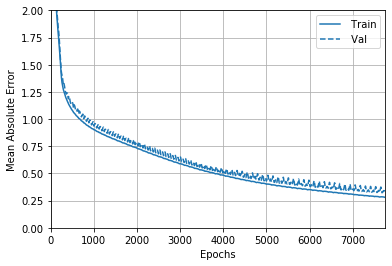

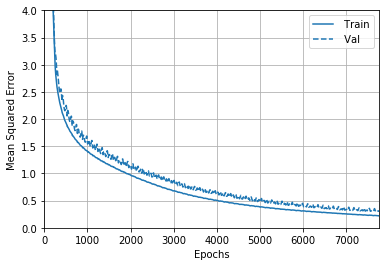

In [48]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 2])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 4])
plt.ylabel('Mean Squared Error')

plt.show()

In [49]:
def average_distance_error(preds, y_test):
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=2)))

904/1 - 0s - loss: 0.6305 - mae: 0.3427 - mse: 0.3170
Test loss: 0.5065935116953555
Mean absolute error: 0.34271514
Mean squared error: 0.31701872
Average distance error: 0.5607253269356544


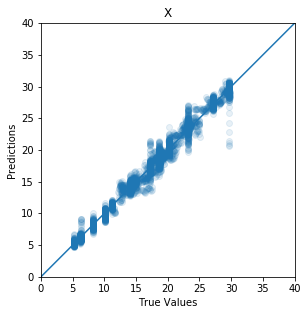

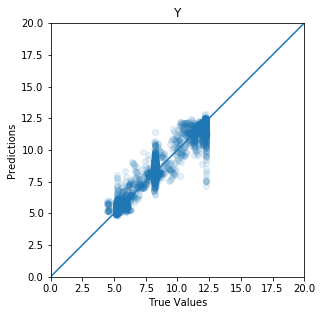

In [50]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Test loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, :, 0], preds[:, :, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_validation[:, :, 1], preds[:, :, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

1289/1 - 0s - loss: 1.5319 - mae: 1.0812 - mse: 2.1661
Test loss: 2.355662520815921
Mean absolute error: 1.0812061
Mean squared error: 2.1660874
Average distance error: 1.7631544678306639


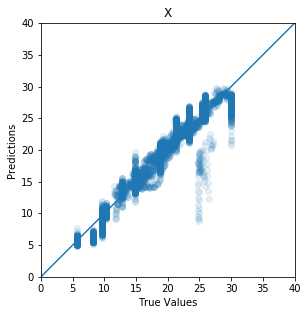

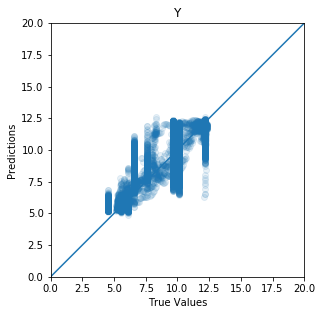

In [51]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, :, 0], preds[:, :, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, :, 1], preds[:, :, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

In [52]:
def cdf(preds, y_test):
    plt.figure(figsize=(10, 10))

    Z = np.sqrt(np.sum(np.square(preds - y_test), axis=2)).reshape(-1)
    N = Z.size

    X = np.sort(Z)
    F = np.array(range(N)) / float(N)
    plt.plot(X, F)
    plt.title('CDF of Euclidean Distance Error')
    plt.xlabel('Euclidean Distance Error (m)')
    plt.ylabel('Density')
    plt.show()

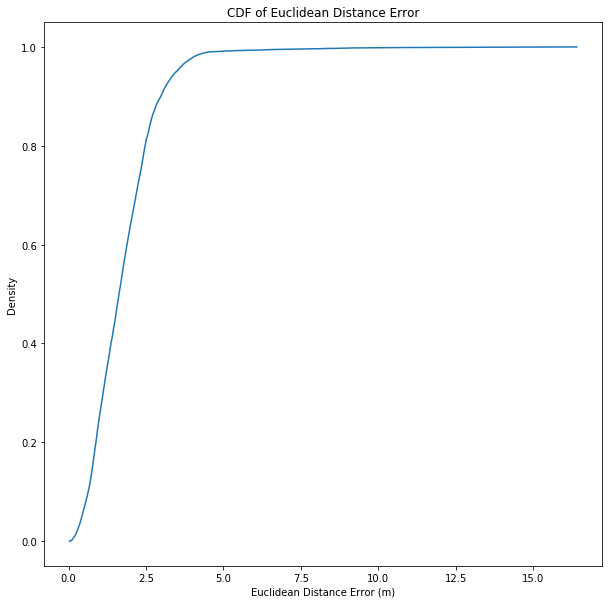

In [53]:
cdf(preds, y_test)

In [54]:
model.save('../Models/LSTM_Stationary_W10.h5')

In [55]:
model.save_weights('../Models/LSTM_Stationary_W10_weights.h5')